# Modeling Climate (Solar Irradiance) Data


## Time Series Forcasing on Climate/Solar Irradiation Data
### Our goal is to forecast future solar irradiance and related climate variables to estimate the solar energy potential in different cities or states

Our data has already been cleaned and formated for time series analysis. We will be looking into using one or 2 different time series forecasting models. See which would be the best fit. Then we will split and train our data and compare the models to see which performs the best.

With model selection we will use it to forcast the upcoming solar irradiation features

In [84]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.vector_ar.var_model import VAR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

In [4]:
solar_df = pd.read_csv('../../data/cleaned_solar_data.csv')
solar_df.head(20)

Date   T2M  T2MWET   RH2M  WS10M  PRECTOTCORR  ALLSKY_SFC_SW_DWN  \
0   2021-01-01  3.72    2.53  85.00   5.15        16.23               0.96   
1   2021-01-02  6.28    5.31  88.00   7.12         3.13               1.83   
2   2021-01-03  4.21    3.62  92.56   7.26         8.93               0.50   
3   2021-01-04  3.82    2.84  87.44   4.89         0.98               1.67   
4   2021-01-05  3.44    2.01  81.69   4.35         0.09               0.95   
5   2021-01-06  2.48    1.02  81.50   7.56         0.00               2.33   
6   2021-01-07  1.69    0.03  79.06   7.11         0.00               2.72   
7   2021-01-08  0.95   -0.58  80.31   5.83         0.00               1.71   
8   2021-01-09  0.18   -1.56  77.69   8.03         0.01               2.35   
9   2021-01-10  1.32   -0.39  78.19   5.70         0.00               2.70   
10  2021-01-11  1.15   -0.40  79.94   2.55         0.01               1.30   
11  2021-01-12  2.74    0.90  78.00   3.14         0.15               2.68   
12  2021-01-13  3.36    1.40  75.62   3.62         0.01               1.81   
13  2021-01-14  4.57    3.87  91.00   2.05         0.08               1.70   
14  2021-01-15  5.68    5.26  94.56   7.61         7.99               1.03   
15  2021-01-16  6.05    5.30  90.31   5.83        23.19               1.44   
16  2021-01-17  3.77    2.30  81.25   8.82         0.02               2.14   
17  2021-01-18  4.00    2.55  81.81   7.15         0.08               2.23   
18  2021-01-19  2.74    1.17  80.19   6.98         0.03               2.17   
19  2021-01-20  1.72   -0.22  75.62   6.39         0.85               2.11   

    CLRSKY_SFC_SW_DWN  ALLSKY_SFC_SW_DIFF  CLRSKY_SFC_SW_DIFF  ALLSKY_KT  \
0                2.51                0.80                0.48       0.26   
1                2.45                0.97                0.63       0.48   
2                2.35                0.39                0.80       0.13   
3                2.47                1.13                0.65       0.44   
4                2.42                0.78                0.75       0.25   
5                2.63                0.80                0.45       0.61   
6                2.71                0.52                0.48       0.70   
7                2.81                1.22                0.40       0.44   
8                2.75                0.90                0.42       0.60   
9                2.81                0.78                0.43       0.68   
10               2.54                1.11                0.84       0.33   
11               2.73                0.72                0.55       0.66   
12               2.50                0.95                0.74       0.45   
13               2.46                1.31                0.97       0.41   
14               2.58                0.81                0.91       0.25   
15               2.71                1.05                0.82       0.34   
16               2.84                1.07                0.59       0.51   
17               2.84                0.97                0.70       0.52   
18               2.95                1.05                0.54       0.51   
19               2.94                0.98                0.64       0.49   

    ALLSKY_SFC_PAR_TOT  CLRSKY_SFC_PAR_TOT  ALLSKY_SFC_UVA  ALLSKY_SFC_UVB  \
0                17.63               45.16            2.46            0.02   
1                32.91               44.13            4.05            0.04   
2                 9.64               42.30            1.42            0.02   
3                29.94               43.72            3.80            0.04   
4                17.61               42.23            2.47            0.02   
5                40.84               46.44            4.71            0.04   
6                46.83               47.22            5.19            0.04   
7                30.03               48.62            3.87            0.04   
8                41.52               49.02            4.88            0.

In [5]:
columns = ['Date', 'City', 'State', 'T2M', 'T2MWET', 'RH2M', 'WS10M', 'PRECTOTCORR',
           'ALLSKY_SFC_SW_DWN', 'CLRSKY_SFC_SW_DWN', 'ALLSKY_SFC_SW_DIFF', 
           'CLRSKY_SFC_SW_DIFF', 'ALLSKY_KT', 'ALLSKY_SFC_PAR_TOT',
           'CLRSKY_SFC_PAR_TOT', 'ALLSKY_SFC_UVA', 'ALLSKY_SFC_UVB', 'ALLSKY_SFC_UV_INDEX']

solar_df = solar_df[columns]
solar_df.head()

Date      City     State   T2M  T2MWET   RH2M  WS10M  PRECTOTCORR  \
0  2021-01-01  New York  New York  3.72    2.53  85.00   5.15        16.23   
1  2021-01-02  New York  New York  6.28    5.31  88.00   7.12         3.13   
2  2021-01-03  New York  New York  4.21    3.62  92.56   7.26         8.93   
3  2021-01-04  New York  New York  3.82    2.84  87.44   4.89         0.98   
4  2021-01-05  New York  New York  3.44    2.01  81.69   4.35         0.09   

   ALLSKY_SFC_SW_DWN  CLRSKY_SFC_SW_DWN  ALLSKY_SFC_SW_DIFF  \
0               0.96               2.51                0.80   
1               1.83               2.45                0.97   
2               0.50               2.35                0.39   
3               1.67               2.47                1.13   
4               0.95               2.42                0.78   

   CLRSKY_SFC_SW_DIFF  ALLSKY_KT  ALLSKY_SFC_PAR_TOT  CLRSKY_SFC_PAR_TOT  \
0                0.48       0.26               17.63               45.16   
1                0.63       0.48               32.91               44.13   
2                0.80       0.13                9.64               42.30   
3                0.65       0.44               29.94               43.72   
4                0.75       0.25               17.61               42.23   

   ALLSKY_SFC_UVA  ALLSKY_SFC_UVB  ALLSKY_SFC_UV_INDEX  
0            2.46            0.02                 0.12  
1            4.05            0.04                 0.20  
2            1.42            0.02                 0.08  
3            3.80            0.04                 0.18  
4            2.47            0.02                 0.11

##### Quick preprocessing below: 

We will make sure the index is set correctly. 
Select the features of interest that we will be forcasting.
Creating a unique identifier for each city/state combination

In [6]:
solar_df.reset_index(inplace=True)

In [7]:
solar_df['Date'] = pd.to_datetime(solar_df['Date'])
solar_df.set_index('Date', inplace=True)

features = [ 'T2M', 'T2MWET', 'RH2M', 'WS10M', 'PRECTOTCORR',
           'ALLSKY_SFC_SW_DWN', 'CLRSKY_SFC_SW_DWN', 'ALLSKY_SFC_SW_DIFF', 
           'CLRSKY_SFC_SW_DIFF', 'ALLSKY_KT', 'ALLSKY_SFC_PAR_TOT',
           'CLRSKY_SFC_PAR_TOT', 'ALLSKY_SFC_UVA', 'ALLSKY_SFC_UVB', 'ALLSKY_SFC_UV_INDEX']

solar_df['City_State'] = solar_df['City'] + ', ' + solar_df['State']

## Split Test / Train Data

Few things to take into consideration for the training and test sets. We need to split data for each city/state combination. We will also Split data before and after Aug 1, 2023 (Which works out to be approx 20% for test). We didn't use the exact 20% of the data so we can make it easy 1st of the month. 

In [8]:
split_date = pd.Timestamp('2023-08-01')

for city_state in solar_df['City_State'].unique():
    print(f"Processing city/state: {city_state}")

    city_data = solar_df[solar_df['City_State'] == city_state][features + ['City_State']]
    
    train_data = city_data[city_data.index < split_date]
    test_data = city_data[city_data.index >= split_date]

Processing city/state: New York, New York
Processing city/state: Los Angeles, California
Processing city/state: Chicago, Illinois
Processing city/state: Houston, Texas
Processing city/state: Phoenix, Arizona
Processing city/state: Philadelphia, Pennsylvania
Processing city/state: San Antonio, Texas
Processing city/state: San Diego, California
Processing city/state: Dallas, Texas
Processing city/state: Jacksonville, Florida
Processing city/state: Fort Worth, Texas
Processing city/state: Austin, Texas
Processing city/state: San Jose, California
Processing city/state: Charlotte, North Carolina
Processing city/state: Columbus, Ohio
Processing city/state: Indianapolis, Indiana
Processing city/state: San Francisco, California
Processing city/state: Seattle, Washington
Processing city/state: Denver, Colorado
Processing city/state: Oklahoma City, Oklahoma
Processing city/state: Nashville, Tennessee
Processing city/state: Washington, District of Columbia
Processing city/state: El Paso, Texas
Pr

In [9]:
test_data.head(20)

T2M  T2MWET   RH2M  WS10M  PRECTOTCORR  ALLSKY_SFC_SW_DWN  \
Date                                                                      
2023-08-01  28.35   26.29  79.44   1.43        11.44               6.69   
2023-08-02  28.32   26.58  82.12   2.93         7.14               5.85   
2023-08-03  28.65   26.47  77.81   3.84         3.51               6.54   
2023-08-04  28.71   26.63  79.00   2.80         0.87               6.51   
2023-08-05  29.29   27.38  80.88   2.23         2.32               6.49   
2023-08-06  30.23   27.92  77.50   2.23         2.16               6.22   
2023-08-07  30.77   28.37  76.75   1.87         0.92               6.87   
2023-08-08  30.88   28.58  77.38   2.38         2.20               6.42   
2023-08-09  30.68   28.03  74.44   2.43         2.13               6.66   
2023-08-10  30.41   27.74  74.44   2.48         2.71               5.82   
2023-08-11  30.14   27.76  77.31   2.45         1.74               6.87   
2023-08-12  29.92   28.01  80.94   2.74         2.74               6.06   
2023-08-13  29.42   27.65  82.25   3.00        14.01               6.69   
2023-08-14  28.91   27.48  85.00   3.06         9.51               5.43   
2023-08-15  29.39   27.47  80.81   2.97         3.76               6.37   
2023-08-16  28.59   27.15  85.06   3.03        12.46               5.46   
2023-08-17  27.65   26.22  84.75   3.57        18.35               4.59   
2023-08-18  27.94   25.97  80.19   2.62         2.99               5.72   
2023-08-19  28.36   26.31  79.12   3.28         1.53               6.53   
2023-08-20  28.55   27.07  84.12   4.37         3.43               4.78   

            CLRSKY_SFC_SW_DWN  ALLSKY_SFC_SW_DIFF  CLRSKY_SFC_SW_DIFF  \
Date                                                                    
2023-08-01               7.28                1.91                2.09   
2023-08-02               7.44                2.48                1.86   
2023-08-03               7.28                2.23                1.96   
2023-08-04               7.18                2.21                2.09   
2023-08-05               7.19                1.82                2.00   
2023-08-06               7.29                2.35                1.76   
2023-08-07               7.40                1.64                1.54   
2023-08-08               7.38                2.01                1.60   
2023-08-09               7.10                2.03                2.22   
2023-08-10               7.19                2.75                2.03   
2023-08-11               7.11                1.92                2.08   
2023-08-12               7.26                2.50                1.68   
2023-08-13               7.19                2.15                1.74   
2023-08-14               6.94                2.58                2.07   
2023-08-15               7.15                2.51                1.89   
2023-08-16               7.23                2.17                1.61   
2023-08-17               7.06                2.60                1.96   
2023-08-18               7.09                1.85                1.88   
2023-08-19               7.07                2.08                1.95   
2023-08-20               6.74                3.20                2.71   

            ALLSKY_KT  ALLSKY_SFC_PAR_TOT  CLRSKY_SFC_PAR_TOT  ALLSKY_SFC_UVA  \
Date                                                                            
2023-08-01       0.62              132.28              141.88           17.13   
2023-08-02       0.54              117.30              145.59           15.68   
2023-08-03       0.60              128.77              141.27           16.73   
2023-08-04       0.60              127.66              138.79           16.46   
2023-08-05       0.60              128.70              140.62           16.71   
2023-08-06       0.58              124.66              143.42           16.53   
2023-08-07       0.64              136.62              145.24           17.80   
2023-08-08       0.59      

## ARIMA vs VAR


        ARIMA  we need to forcast each time series variable independently. This would mean we would have to apply ARIMA or SARIMA to each of the variables, then we would also need to filter the data for each city/state combination and then apply the model. 
        We can look into forecast multiple variables while considering interactions between them. There are a few Multivariate time Series models. Vector Autoregression is an extension of ARIMA that will allow us to handle multiple time series simultaneously and model the relationships between them.
        
        The downside of VAR is that we still need to complete this for each city one by one. Since there maybe multiple cities with the same name but in different states we need to combine the city and state so we don't get inaccurate data. 

##### VAR

In [10]:
all_forecasts = []
all_actuals = []

for city_state in solar_df['City_State'].unique():
    print(f"Fitting and forecasting for city/state: {city_state}")

    city_data = solar_df[solar_df['City_State'] == city_state]

    train_data = city_data[city_data.index < split_date][features]
    test_data = city_data[city_data.index >= split_date][features]
    train_data_diff = train_data.diff().dropna()

    model = VAR(train_data_diff)
    model_fit = model.fit(maxlags=15, ic='aic')

    forecast = model_fit.forecast(train_data_diff.values[-model_fit.k_ar:], steps=len(test_data))

    forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=features)

    forecast_df = forecast_df.cumsum() + train_data.iloc[-1]

    forecast_df['City_State'] = city_state

    test_data['City_State'] = city_state

    all_forecasts.append(forecast_df)
    all_actuals.append(test_data)

all_forecasts_df = pd.concat(all_forecasts)
all_actuals_df = pd.concat(all_actuals)

Fitting and forecasting for city/state: New York, New York


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Los Angeles, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Chicago, Illinois


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Houston, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Phoenix, Arizona


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Philadelphia, Pennsylvania


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: San Antonio, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: San Diego, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Dallas, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Jacksonville, Florida


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Fort Worth, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Austin, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: San Jose, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Charlotte, North Carolina


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Columbus, Ohio


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Indianapolis, Indiana


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: San Francisco, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Seattle, Washington


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Denver, Colorado


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Oklahoma City, Oklahoma


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Nashville, Tennessee


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Washington, District of Columbia


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: El Paso, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Las Vegas, Nevada


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Boston, Massachusetts


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Detroit, Michigan


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Portland, Oregon


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Louisville, Kentucky


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Memphis, Tennessee


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Baltimore, Maryland


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Albuquerque, New Mexico


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Milwaukee, Wisconsin


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Tucson, Arizona


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Fresno, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Sacramento, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Atlanta, Georgia


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Mesa, Arizona


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Kansas City, Missouri


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Colorado Springs, Colorado


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Raleigh, North Carolina


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Omaha, Nebraska


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Miami, Florida


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Virginia Beach, Virginia


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Long Beach, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Oakland, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Minneapolis, Minnesota


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Bakersfield, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Tulsa, Oklahoma


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Tampa, Florida


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Arlington, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Aurora, Colorado


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Wichita, Kansas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Cleveland, Ohio


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: New Orleans, Louisiana


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Henderson, Nevada


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Honolulu, Hawaii


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Anaheim, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Orlando, Florida


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Riverside, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Lexington, Kentucky


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Stockton, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Irvine, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Corpus Christi, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Cincinnati, Ohio


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Santa Ana, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Greensboro, North Carolina


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Pittsburgh, Pennsylvania


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Newark, New Jersey


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: St. Paul, Minnesota


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Durham, North Carolina


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Lincoln, Nebraska


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: North Las Vegas, Nevada


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Jersey City, New Jersey


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Plano, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Anchorage, Alaska


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Madison, Wisconsin


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Chandler, Arizona


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Reno, Nevada


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Gilbert, Arizona


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: St. Louis, Missouri


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Chula Vista, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Buffalo, New York


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Fort Wayne, Indiana


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Lubbock, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: St. Petersburg, Florida


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Toledo, Ohio


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Laredo, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Port St. Lucie, Florida


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Glendale, Arizona


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Chesapeake, Virginia


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Winston, North Carolina


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Irving, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Scottsdale, Arizona


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Garland, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Enterprise, Nevada


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Arlington, Virginia


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Boise, Idaho


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Cape Coral, Florida


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Frisco, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Richmond, Virginia


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Spokane, Washington


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Norfolk, Virginia


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Huntsville, Alabama


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Fremont, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: San Bernardino, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Tacoma, Washington


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Spring Valley, Nevada


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Santa Clarita, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Hialeah, Florida


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Modesto, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: McKinney, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Fontana, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Baton Rouge, Louisiana


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Moreno Valley, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Salt Lake City, Utah


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Sioux Falls, South Dakota


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Fayetteville, North Carolina


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Des Moines, Iowa


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Worcester, Massachusetts


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Yonkers, New York


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Rochester, New York


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Little Rock, Arkansas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Grand Prairie, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Tallahassee, Florida


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Amarillo, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Peoria, Arizona


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Augusta, Georgia


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Knoxville, Tennessee


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Columbus, Georgia


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Sunrise Manor, Nevada


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Vancouver, Washington


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Oxnard, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Overland Park, Kansas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Grand Rapids, Michigan


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Birmingham, Alabama


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Montgomery, Alabama


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Tempe, Arizona


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Brownsville, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Providence, Rhode Island


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Huntington Beach, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Paradise, Nevada


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Chattanooga, Tennessee


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Akron, Ohio


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Clarksville, Tennessee


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Fort Lauderdale, Florida


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Ontario, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Glendale, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Newport News, Virginia


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Cary, North Carolina


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Mobile, Alabama


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Elk Grove, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Eugene, Oregon


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Salem, Oregon


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Aurora, Illinois


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Santa Rosa, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Shreveport, Louisiana


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Rancho Cucamonga, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Pembroke Pines, Florida


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Springfield, Missouri


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Fort Collins, Colorado


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Murfreesboro, Tennessee


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Oceanside, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Garden Grove, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Denton, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Lancaster, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Surprise, Arizona


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Roseville, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Killeen, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Corona, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Palmdale, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Salinas, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Charleston, South Carolina


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Macon, Georgia


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Lakewood, Colorado


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Paterson, New Jersey


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Hollywood, Florida


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Alexandria, Virginia


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Hayward, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Springfield, Massachusetts


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Kansas City, Kansas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Bellevue, Washington


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Sunnyvale, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Joliet, Illinois


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Naperville, Illinois


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Olathe, Kansas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Bridgeport, Connecticut


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: McAllen, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Savannah, Georgia


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Escondido, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Gainesville, Florida


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Mesquite, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Waco, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Visalia, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Thornton, Colorado


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Rockford, Illinois


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Syracuse, New York


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Pasadena, Texas


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Columbia, South Carolina


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Pomona, California


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting and forecasting for city/state: Palm Bay, Florida


C:\Users\darde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


##### VAR Evaluation Metrics



In [11]:
all_actuals_df = all_actuals_df.sort_index()
all_forecasts_df = all_forecasts_df.sort_index()

r2_scores = {}

for feature in features:
    actual = all_actuals_df[feature]
    predicted = all_forecasts_df[feature]
    
    r2 = r2_score(actual, predicted)
    
    r2_scores[feature] = r2

print("R-squared values for all features:")
for feature, r2 in r2_scores.items():
    print(f"{feature}: {r2}")

R-squared values for all features:
T2M: -2.1537222387796895
T2MWET: -1.7142326043626595
RH2M: -0.4411755077702646
WS10M: -0.13419375652038124
PRECTOTCORR: -0.1687323652794963
ALLSKY_SFC_SW_DWN: -2.5140333245132536
CLRSKY_SFC_SW_DWN: -3.2516851812646737
ALLSKY_SFC_SW_DIFF: -1.7287180340853174
CLRSKY_SFC_SW_DIFF: -3.0457726848254216
ALLSKY_KT: -0.29362193920175517
ALLSKY_SFC_PAR_TOT: -2.8279575724921084
CLRSKY_SFC_PAR_TOT: -3.4623311140493263
ALLSKY_SFC_UVA: -3.037362599950381
ALLSKY_SFC_UVB: -4.202648600733977
ALLSKY_SFC_UV_INDEX: -4.352104331700811


#### Notes: We have negative numbers this could be due to our data note being fully stationary. This being a very complex dataset, we need to look at alternatives. 

## LSTM

#### We are going to start by normalizing the data. 


In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_data_scaled = scaler.fit_transform(train_data[features])
test_data_scaled = scaler.transform(test_data[features])

In [13]:
# Store to DF not sure if this step is requred. but it should be easier later
train_data_scaled = pd.DataFrame(train_data_scaled, columns=features, index=train_data.index)
test_data_scaled = pd.DataFrame(test_data_scaled, columns=features, index=test_data.index)

### Create Sequences for LSTM

Sequential data is 3D shape. They work with sequential data where order of the data points matter. So we need to define create_sequenses function and will take last 30 steps. 

In [14]:
def create_sequences(data, time_steps=30):
    sequences, labels = [], []
    for i in range(len(data) - time_steps):
        seq = data.iloc[i:(i + time_steps)].values
        label = data.iloc[i + time_steps].values
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)


X_train, y_train = create_sequences(train_data_scaled)
X_test, y_test = create_sequences(test_data_scaled)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (912, 30, 15)
y_train shape: (912, 15)
X_test shape: (214, 30, 15)
y_test shape: (214, 15)


#### Define LSTM
    To define the model we will use 50 neurons for our lstm layer. With 25 units in this dense layer to reduce the dimensionality. We will use our optimizer as Adam

In [15]:
# We also have to define the LSTM model. We have to input the shape for xtrain. And output layer for the same number of features

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(len(features))) 

model.compile(optimizer='adam', loss='mean_squared_error')

#### Train Model

- Few things to note. We don't want the model to overfit to we will use 20 epoches and the default 32 batch size. 

In [16]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)

test_predictions = model.predict(X_test)

7/7 [==============================] - 1s 11ms/step


In [17]:
#Reverse the scaler transformation
test_predictions = scaler.inverse_transform(test_predictions)
y_test_actual = scaler.inverse_transform(y_test)

In [18]:
ls_forecasts = test_predictions
ls_actuals = y_test_actual

In [19]:
print("Predictions shape:", test_predictions.shape)
print("Actual values shape:", y_test_actual.shape)

Predictions shape: (214, 15)
Actual values shape: (214, 15)


In [20]:
mae = mean_absolute_error(ls_actuals, ls_forecasts)
mse = mean_squared_error(ls_actuals, ls_forecasts)
rmse = np.sqrt(mse)
r2 = r2_score(ls_actuals, ls_forecasts)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

Mean Absolute Error (MAE): 2.530454906729702
Mean Squared Error (MSE): 35.43325701976834
Root Mean Squared Error (RMSE): 5.952584062385708
R-squared: 0.4495776652384264


###### Performance wasn't that great. So let's do some minor hyperperameter tuning

We are goig to use Grid Search so it gives us the best set of hyperparameters and their performance metrics. We will wrap the model with the kerasRegressor

In [25]:
def create_lstm_model(lstm_units=50, dense_units=25, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(lstm_units))
    model.add(Dense(dense_units))
    model.add(Dense(len(features)))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

model = KerasRegressor(build_fn=create_lstm_model, verbose=0)

C:\Users\darde\AppData\Local\Temp\ipykernel_1004\498631110.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_lstm_model, verbose=0)


In [24]:

param_grid = {
    'lstm_units': [50, 100],
    'dense_units': [25, 50],
    'batch_size': [32, 64],
    'epochs': [20, 50],
    'learning_rate': [0.001, 0.01]
}


grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

grid_result = grid.fit(X_train, y_train)


print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best: -0.011880449019372463 using {'batch_size': 64, 'dense_units': 50, 'epochs': 50, 'learning_rate': 0.01, 'lstm_units': 50}


In [27]:
best_model = grid_result.best_estimator_

test_predictions = best_model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)
y_test_actual = scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_actual, test_predictions)
mse = mean_squared_error(y_test_actual, test_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, test_predictions)

print(f"Best Model Performance:\nMAE: {mae}\nMSE: {mse}\nRMSE: {rmse}\nR-squared: {r2}")

Best Model Performance:
MAE: 2.3117460685933935
MSE: 29.310523342393825
RMSE: 5.413919406713941
R-squared: 0.5327639866819557


#### Visualize the results

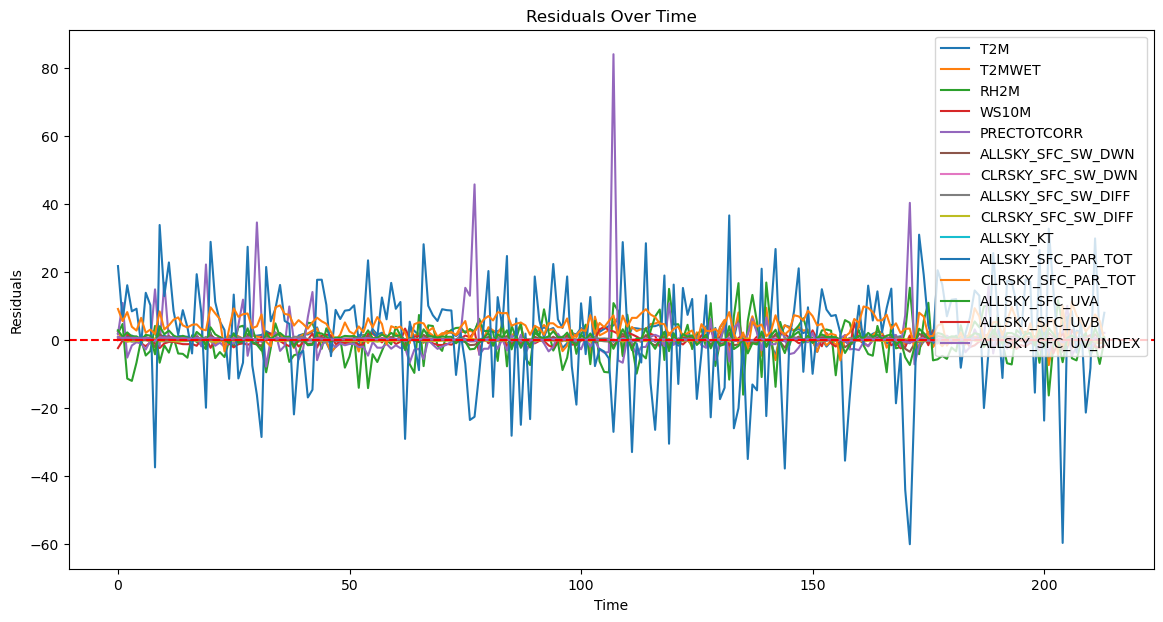

In [28]:

residuals = y_test_actual - test_predictions
residuals_df = pd.DataFrame(residuals, columns=features)

plt.figure(figsize=(14, 7))
plt.plot(residuals_df)
plt.title('Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.legend(features, loc='upper right')
plt.show()

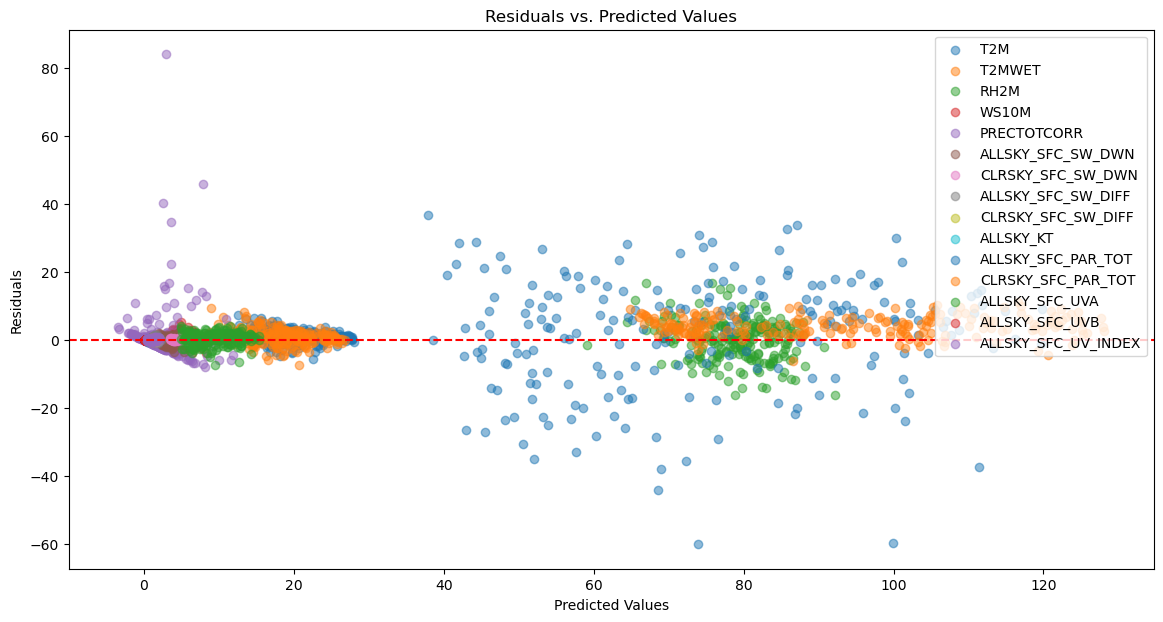

In [29]:
plt.figure(figsize=(14, 7))

for feature in features:
    plt.scatter(test_predictions[:, features.index(feature)], residuals_df[feature], label=feature, alpha=0.5)

plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.legend(loc='upper right')
plt.show()

### Cross-validation 
We are going to see if CV will help us improve our model

In [32]:

model = KerasRegressor(build_fn=create_lstm_model, epochs=20, batch_size=32, verbose=0)

tscv = TimeSeriesSplit(n_splits=5)
cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

mse_scores = -cv_results
rmse_scores = np.sqrt(mse_scores)

print(f"Cross-validated RMSE scores: {rmse_scores}")
print(f"Mean RMSE: {rmse_scores.mean()}")
print(f"Standard Deviation of RMSE: {rmse_scores.std()}")

C:\Users\darde\AppData\Local\Temp\ipykernel_1004\1942433496.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_lstm_model, epochs=20, batch_size=32, verbose=0)


Cross-validated RMSE scores: [0.14992112 0.12915419 0.11865842 0.11399641 0.11798514]
Mean RMSE: 0.12594305673395612
Standard Deviation of RMSE: 0.012995193842832872


The cross-validation results showed consistent and low RMSE scores, suggesting that the model generally performs well across different folds. However, the final model’s RMSE on the test set is much higher, indicating that it might not generalize as well as the cross-validation suggested.

# Part 2 : Weighted Scoring Model for Solar Energy Recommendation

Now that we have created a Solar Irradiation forcast model, we are now going to part 2 of the modelling. 

Our goal is to now create a recommendation system for solar energy targeting that involves identifying the best states or cities based on multiple factors. We will be created a weighted scoring model as it allows us to assign different importance levels to each factor.

Steps:
###### 1) Identify Key factors - Determine the factors that will influence the recommendation sytem. Common factors might include:
    Solar Irradiance - The amount of solar energy received, typically measured in kWh/m²/day.
    Electricity Cost - Higher electricity prices make solar energy more attractive.
    Homeownership Rates - Higher rates suggest a larger potential customer base
    Population Size - Larger populations can lead to more potential customers.
    Climate Factors - Weather conditions, average temperature, and cloud cover.
    Median Household Income - Higher income might correlate with a greater likelihood of adopting solar energy
    Averaged Monthly Electricity costs - Higher electricity costs make solar energy more attractive
    Total Monthly Electricity Spending - highlight states where there's significant electricity consumption.
    
###### 2) Assign Weights to Each Factor - Decide how important each factor is relative to the others.

###### 3) Normalize the Data - make sure they are all on the same scale

###### 4) Calculate the Weighted Scores:

###### 5) Rank the Cities or States: Based on the weighted scores, rank the cities or states to identify the best ones to target

## 1) Define the Factors and Weights

 Given the differences in granularity (daily vs. monthly vs. no dates) and the varying levels of aggregation (city vs. state), merging these datasets directly might not be straightforward. However, we can still work with them effectively by aligning the data appropriately for analysis.
 
 Steps to Handle and Align Data:
Aggregate Daily Solar Data: 
1) Aggregate the daily solar data to a monthly level to match the granularity of the EIA data.

2) Align City and State Data: Match the aggregated solar data with the census data and EIA data, recognizing that the census data is at the city level, while the EIA data is at the state level.

3) Merge Data: Combine the datasets by aligning the city-level solar and census data with the state-level EIA data.

In [5]:
solar_df2 = pd.read_csv('../../data/cleaned_solar_data.csv')

columns = ['Date', 'City', 'State', 'T2M', 'T2MWET', 'RH2M', 'WS10M', 'PRECTOTCORR',
           'ALLSKY_SFC_SW_DWN', 'CLRSKY_SFC_SW_DWN', 'ALLSKY_SFC_SW_DIFF', 
           'CLRSKY_SFC_SW_DIFF', 'ALLSKY_KT', 'ALLSKY_SFC_PAR_TOT',
           'CLRSKY_SFC_PAR_TOT', 'ALLSKY_SFC_UVA', 'ALLSKY_SFC_UVB', 'ALLSKY_SFC_UV_INDEX']

solar_df2 = solar_df2[columns]
solar_df2['Date'] = pd.to_datetime(solar_df2['Date'])
solar_df2.set_index('Date', inplace=True)

solar_df2.head()

City     State   T2M  T2MWET   RH2M  WS10M  PRECTOTCORR  \
Date                                                                      
2021-01-01  New York  New York  3.72    2.53  85.00   5.15        16.23   
2021-01-02  New York  New York  6.28    5.31  88.00   7.12         3.13   
2021-01-03  New York  New York  4.21    3.62  92.56   7.26         8.93   
2021-01-04  New York  New York  3.82    2.84  87.44   4.89         0.98   
2021-01-05  New York  New York  3.44    2.01  81.69   4.35         0.09   

            ALLSKY_SFC_SW_DWN  CLRSKY_SFC_SW_DWN  ALLSKY_SFC_SW_DIFF  \
Date                                                                   
2021-01-01               0.96               2.51                0.80   
2021-01-02               1.83               2.45                0.97   
2021-01-03               0.50               2.35                0.39   
2021-01-04               1.67               2.47                1.13   
2021-01-05               0.95               2.42                0.78   

            CLRSKY_SFC_SW_DIFF  ALLSKY_KT  ALLSKY_SFC_PAR_TOT  \
Date                                                            
2021-01-01                0.48       0.26               17.63   
2021-01-02                0.63       0.48               32.91   
2021-01-03                0.80       0.13                9.64   
2021-01-04                0.65       0.44               29.94   
2021-01-05                0.75       0.25               17.61   

            CLRSKY_SFC_PAR_TOT  ALLSKY_SFC_UVA  ALLSKY_SFC_UVB  \
Date                                                             
2021-01-01               45.16            2.46            0.02   
2021-01-02               44.13            4.05            0.04   
2021-01-03               42.30            1.42            0.02   
2021-01-04               43.72            3.80            0.04   
2021-01-05               42.23            2.47            0.02   

            ALLSKY_SFC_UV_INDEX  
Date                             
2021-01-01                 0.12  
2021-01-02                 0.20  
2021-01-03                 0.08  
2021-01-04                 0.18  
2021-01-05                 0.11

In [7]:
non_numeric_columns = solar_df2.select_dtypes(exclude=[np.number]).columns
print(non_numeric_columns)

Index(['City', 'State'], dtype='object')


In [9]:
monthly_mean_df = solar_df2.groupby(['City', 'State']).resample('M').mean().reset_index()


In [10]:
monthly_mean_df.head(50)


City       State       Date        T2M     T2MWET       RH2M  \
0         Akron        Ohio 2021-01-31  -2.263548  -3.214194  88.117097   
1         Akron        Ohio 2021-02-28  -4.277857  -5.275000  88.049286   
2         Akron        Ohio 2021-03-31   5.019677   2.741613  75.093871   
3         Akron        Ohio 2021-04-30   9.514000   7.101333  74.508333   
4         Akron        Ohio 2021-05-31  14.499355  11.470000  70.314516   
5         Akron        Ohio 2021-06-30  22.242667  18.925667  69.298333   
6         Akron        Ohio 2021-07-31  22.596774  19.506129  71.356774   
7         Akron        Ohio 2021-08-31  23.625484  20.485161  71.499355   
8         Akron        Ohio 2021-09-30  19.032333  15.789333  69.607667   
9         Akron        Ohio 2021-10-31  14.976774  12.965806  79.390645   
10        Akron        Ohio 2021-11-30   3.230000   1.324000  78.335000   
11        Akron        Ohio 2021-12-31   2.562581   1.340000  84.993548   
12        Akron        Ohio 2022-01-31  -5.750968  -6.860645  86.141290   
13        Akron        Ohio 2022-02-28  -2.727143  -3.757500  87.673214   
14        Akron        Ohio 2022-03-31   3.983871   2.417419  81.407419   
15        Akron        Ohio 2022-04-30   7.727667   5.732000  78.368333   
16        Akron        Ohio 2022-05-31  16.664839  14.457742  77.898710   
17        Akron        Ohio 2022-06-30  20.743333  17.158667  67.586000   
18        Akron        Ohio 2022-07-31  23.826774  19.876129  65.576774   
19        Akron        Ohio 2022-08-31  22.836774  19.265806  68.418710   
20        Akron        Ohio 2022-09-30  18.130667  15.247333  72.730333   
21        Akron        Ohio 2022-10-31   9.926452   6.743226  68.528710   
22        Akron        Ohio 2022-11-30   5.265333   3.050333  75.400333   
23        Akron        Ohio 2022-12-31  -1.126452  -2.371290  84.267097   
24        Akron        Ohio 2023-01-31   0.434839  -0.387742  89.356774   
25        Akron        Ohio 2023-02-28   1.210714  -0.492857  79.560000   
26        Akron        Ohio 2023-03-31   2.591613   0.873226  80.160968   
27        Akron        Ohio 2023-04-30  10.143667   7.614000  74.112333   
28        Akron        Ohio 2023-05-31  14.538710  11.055161  67.373871   
29        Akron        Ohio 2023-06-30  19.421667  15.448667  64.527000   
30        Akron        Ohio 2023-07-31  23.325806  19.945161  69.329355   
31        Akron        Ohio 2023-08-31  21.286452  18.331613  72.568387   
32        Akron        Ohio 2023-09-30  18.673000  15.750000  72.441333   
33        Akron        Ohio 2023-10-31  12.260968   9.670323  74.080645   
34        Akron        Ohio 2023-11-30   4.317000   1.969000  74.426667   
35        Akron        Ohio 2023-12-31   3.035484   1.892258  86.015161   
36        Akron        Ohio 2024-01-31  -2.560968  -3.494839  87.748710   
37        Akron        Ohio 2024-02-29   1.206897  -0.236552  82.724138   
38        Akron        Ohio 2024-03-31   5.529032   3.778387  80.094194   
39  Albuquerque  New Mexico 2021-01-31   1.401290  -3.423226  51.604516   
40  Albuquerque  New Mexico 2021-02-28   3.578214  -2.438929  45.099643   
41  Albuquerque  New Mexico 2021-03-31   7.525161  -0.063548  37.422903   
42  Albuquerque  New Mexico 2021-04-30  13.970000   3.758333  28.162000   
43  Albuquerque  New Mexico 2021-05-31  19.696774   8.390323  26.611935   
44  Albuquerque  New Mexico 2021-06-30  26.034667  14.966333  30.010000   
45  Albuquerque  New Mexico 2021-07-31  25.644194  19.469355  50.039355   
46  Albuquerque  New Mexico 2021-08-31  25.000323  18.056452  46.477742   
47  Albuquerque  New Mexico 2021-09-30  21.941667  14.485333  43.541667   
48  Albuquerque  New Mexico 2021-10-31  13.636452   6.446452  40.760323   
49  Albuquerque  New Mexico 2021-11-30   9.209667   2.512000  41.769333   

       WS10M  PRECTOTCORR  ALLSKY_SFC_SW_DWN  CLRSKY_SFC_SW_DWN  \
0   3.104516     1.218065           1.298710           2.768065   
1   3.665000     1.519286           2.378929       

In [11]:
stats_summary = monthly_mean_df.describe()

In [14]:
stats_summary = monthly_mean_df.describe()

In [15]:

city_state_df = monthly_mean_df[(monthly_mean_df['City'] == 'New York') & (monthly_mean_df['State'] == 'New York')]

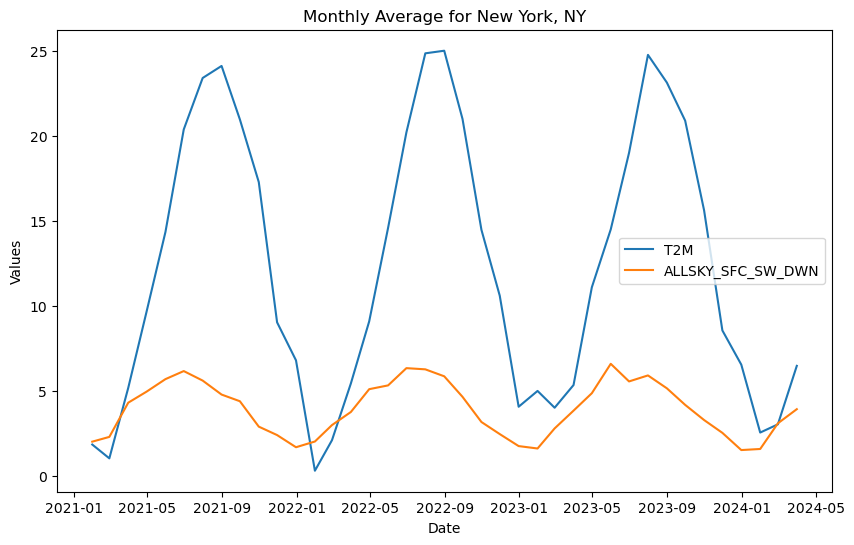

Date          T2M       T2MWET         RH2M  \
count                           7800  7800.000000  7800.000000  7800.000000   
mean   2022-08-30 14:09:13.846153984    15.530774    11.712677    67.220845   
min              2021-01-31 00:00:00   -14.469032   -15.278065    14.010645   
25%              2021-10-31 00:00:00     9.180565     5.769435    58.589989   
50%              2022-08-31 00:00:00    15.574516    11.720645    72.666290   
75%              2023-06-30 00:00:00    23.076516    18.134583    79.026735   
max              2024-03-31 00:00:00    37.249032    27.846452    96.832581   
std                              NaN     9.232522     8.297719    16.945609   

             WS10M  PRECTOTCORR  ALLSKY_SFC_SW_DWN  CLRSKY_SFC_SW_DWN  \
count  7800.000000  7800.000000        7800.000000        7800.000000   
mean      3.535828     2.294064           4.685001           5.780892   
min       1.122258     0.000000           0.163226           0.251613   
25%       2.697667     0.674417           3.230714           4.110484   
50%       3.391020     1.864839           4.742258           5.966935   
75%       4.254853     3.392016           6.009194           7.521210   
max       8.220323    13.294667           8.666667           9.050667   
std       1.106865     2.004342           1.751414           1.847093   

       ALLSKY_SFC_SW_DIFF  CLRSKY_SFC_SW_DIFF    ALLSKY_KT  \
count         7800.000000         7800.000000  7800.000000   
mean             1.553189            1.167537     0.570506   
min              0.102581            0.077097     0.269677   
25%              1.062823            0.739149     0.516452   
50%              1.467903            1.062258     0.566129   
75%              1.988710            1.504000     0.630323   
max              3.517742            2.803871     0.773667   
std              0.568684            0.521365     0.086536   

       ALLSKY_SFC_PAR_TOT  CLRSKY_SFC_PAR_TOT  ALLSKY_SFC_UVA  ALLSKY_SFC_UVB  \
count         7800.000000         7800.000000     7800.000000     7800.000000   
mean            87.655396          107.042310       11.349330        0.253647   
min              2.368387            3.750000        0.307419        0.000000   
25%             59.029677           75.268333        7.389667        0.122714   
50%             88.219780          109.316774       11.386452        0.242785   
75%            114.964040          140.879355       15.054927        0.372927   
max            161.618667          166.027333       21.187667        0.634516   
std             34.018404           35.453869        4.586581        0.146935   

       ALLSKY_SFC_UV_INDEX  
count          7800.000000  
mean              1.288243  
min               0.009677  
25%               0.615540  
50%               1.225028  
75%               1.887661  
max               3.406129  
std               0.759398

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(city_state_df['Date'], city_state_df['T2M'], label='T2M')
plt.plot(city_state_df['Date'], city_state_df['ALLSKY_SFC_SW_DWN'], label='ALLSKY_SFC_SW_DWN')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Monthly Average for New York, NY')
plt.legend()
plt.show()


stats_summary

So it looks like it completed sucessfully, we were able to conver the daily data to monthy for each city and use the monthly average. 

One thing to note is the date for each month is on it's month end, we want to reflect it to be the 1st as that is how the EIA data is setup. 

In [18]:
monthly_mean_df['Date'] = monthly_mean_df['Date'].apply(lambda x: x.replace(day=1))


In [19]:
monthly_mean_df.head(50)

City       State       Date        T2M     T2MWET       RH2M  \
0         Akron        Ohio 2021-01-01  -2.263548  -3.214194  88.117097   
1         Akron        Ohio 2021-02-01  -4.277857  -5.275000  88.049286   
2         Akron        Ohio 2021-03-01   5.019677   2.741613  75.093871   
3         Akron        Ohio 2021-04-01   9.514000   7.101333  74.508333   
4         Akron        Ohio 2021-05-01  14.499355  11.470000  70.314516   
5         Akron        Ohio 2021-06-01  22.242667  18.925667  69.298333   
6         Akron        Ohio 2021-07-01  22.596774  19.506129  71.356774   
7         Akron        Ohio 2021-08-01  23.625484  20.485161  71.499355   
8         Akron        Ohio 2021-09-01  19.032333  15.789333  69.607667   
9         Akron        Ohio 2021-10-01  14.976774  12.965806  79.390645   
10        Akron        Ohio 2021-11-01   3.230000   1.324000  78.335000   
11        Akron        Ohio 2021-12-01   2.562581   1.340000  84.993548   
12        Akron        Ohio 2022-01-01  -5.750968  -6.860645  86.141290   
13        Akron        Ohio 2022-02-01  -2.727143  -3.757500  87.673214   
14        Akron        Ohio 2022-03-01   3.983871   2.417419  81.407419   
15        Akron        Ohio 2022-04-01   7.727667   5.732000  78.368333   
16        Akron        Ohio 2022-05-01  16.664839  14.457742  77.898710   
17        Akron        Ohio 2022-06-01  20.743333  17.158667  67.586000   
18        Akron        Ohio 2022-07-01  23.826774  19.876129  65.576774   
19        Akron        Ohio 2022-08-01  22.836774  19.265806  68.418710   
20        Akron        Ohio 2022-09-01  18.130667  15.247333  72.730333   
21        Akron        Ohio 2022-10-01   9.926452   6.743226  68.528710   
22        Akron        Ohio 2022-11-01   5.265333   3.050333  75.400333   
23        Akron        Ohio 2022-12-01  -1.126452  -2.371290  84.267097   
24        Akron        Ohio 2023-01-01   0.434839  -0.387742  89.356774   
25        Akron        Ohio 2023-02-01   1.210714  -0.492857  79.560000   
26        Akron        Ohio 2023-03-01   2.591613   0.873226  80.160968   
27        Akron        Ohio 2023-04-01  10.143667   7.614000  74.112333   
28        Akron        Ohio 2023-05-01  14.538710  11.055161  67.373871   
29        Akron        Ohio 2023-06-01  19.421667  15.448667  64.527000   
30        Akron        Ohio 2023-07-01  23.325806  19.945161  69.329355   
31        Akron        Ohio 2023-08-01  21.286452  18.331613  72.568387   
32        Akron        Ohio 2023-09-01  18.673000  15.750000  72.441333   
33        Akron        Ohio 2023-10-01  12.260968   9.670323  74.080645   
34        Akron        Ohio 2023-11-01   4.317000   1.969000  74.426667   
35        Akron        Ohio 2023-12-01   3.035484   1.892258  86.015161   
36        Akron        Ohio 2024-01-01  -2.560968  -3.494839  87.748710   
37        Akron        Ohio 2024-02-01   1.206897  -0.236552  82.724138   
38        Akron        Ohio 2024-03-01   5.529032   3.778387  80.094194   
39  Albuquerque  New Mexico 2021-01-01   1.401290  -3.423226  51.604516   
40  Albuquerque  New Mexico 2021-02-01   3.578214  -2.438929  45.099643   
41  Albuquerque  New Mexico 2021-03-01   7.525161  -0.063548  37.422903   
42  Albuquerque  New Mexico 2021-04-01  13.970000   3.758333  28.162000   
43  Albuquerque  New Mexico 2021-05-01  19.696774   8.390323  26.611935   
44  Albuquerque  New Mexico 2021-06-01  26.034667  14.966333  30.010000   
45  Albuquerque  New Mexico 2021-07-01  25.644194  19.469355  50.039355   
46  Albuquerque  New Mexico 2021-08-01  25.000323  18.056452  46.477742   
47  Albuquerque  New Mexico 2021-09-01  21.941667  14.485333  43.541667   
48  Albuquerque  New Mexico 2021-10-01  13.636452   6.446452  40.760323   
49  Albuquerque  New Mexico 2021-11-01   9.209667   2.512000  41.769333   

       WS10M  PRECTOTCORR  ALLSKY_SFC_SW_DWN  CLRSKY_SFC_SW_DWN  \
0   3.104516     1.218065           1.298710           2.768065   
1   3.665000     1.519286           2.378929       

Next we are going to align the aggregated solar data with the census data and EIA data. We will start by mergin the solar data (which includes city and state information) with the census data based on the City and State columns. 

In [25]:
census_data = pd.read_csv('../../data/census_df_sorted.csv')


merged_solar_census = pd.merge(monthly_mean_df, census_data, left_on=['City', 'State'], right_on=['City', 'State'], how='inner')


print(merged_solar_census)

Empty DataFrame
Columns: [City, State, Date, T2M, T2MWET, RH2M, WS10M, PRECTOTCORR, ALLSKY_SFC_SW_DWN, CLRSKY_SFC_SW_DWN, ALLSKY_SFC_SW_DIFF, CLRSKY_SFC_SW_DIFF, ALLSKY_KT, ALLSKY_SFC_PAR_TOT, CLRSKY_SFC_PAR_TOT, ALLSKY_SFC_UVA, ALLSKY_SFC_UVB, ALLSKY_SFC_UV_INDEX, Total_Population, Median_Household_Income, Median_Home_Value, 1_Unit_Detached, 1_Unit_Attached, Total_1_Unit]
Index: []

[0 rows x 24 columns]


In [26]:
solar_aggregated = monthly_mean_df 

print("Unique Cities in Solar Data:", solar_aggregated['City'].unique())
print("Unique States in Solar Data:", solar_aggregated['State'].unique())

print("Unique Cities in Census Data:", census_data['City'].unique())
print("Unique States in Census Data:", census_data['State'].unique())

Unique Cities in Solar Data: ['Akron' 'Albuquerque' 'Alexandria' 'Amarillo' 'Anaheim' 'Anchorage'
 'Arlington' 'Atlanta' 'Augusta' 'Aurora' 'Austin' 'Bakersfield'
 'Baltimore' 'Baton Rouge' 'Bellevue' 'Birmingham' 'Boise' 'Boston'
 'Bridgeport' 'Brownsville' 'Buffalo' 'Cape Coral' 'Cary' 'Chandler'
 'Charleston' 'Charlotte' 'Chattanooga' 'Chesapeake' 'Chicago'
 'Chula Vista' 'Cincinnati' 'Clarksville' 'Cleveland' 'Colorado Springs'
 'Columbia' 'Columbus' 'Corona' 'Corpus Christi' 'Dallas' 'Denton'
 'Denver' 'Des Moines' 'Detroit' 'Durham' 'El Paso' 'Elk Grove'
 'Enterprise' 'Escondido' 'Eugene' 'Fayetteville' 'Fontana' 'Fort Collins'
 'Fort Lauderdale' 'Fort Wayne' 'Fort Worth' 'Fremont' 'Fresno' 'Frisco'
 'Gainesville' 'Garden Grove' 'Garland' 'Gilbert' 'Glendale'
 'Grand Prairie' 'Grand Rapids' 'Greensboro' 'Hayward' 'Henderson'
 'Hialeah' 'Hollywood' 'Honolulu' 'Houston' 'Huntington Beach'
 'Huntsville' 'Indianapolis' 'Irvine' 'Irving' 'Jacksonville'
 'Jersey City' 'Joliet' 'Kansas 

It looks like there were leading and trailing spaces. 

In [27]:
solar_aggregated['City'] = solar_aggregated['City'].str.strip().str.title()
solar_aggregated['State'] = solar_aggregated['State'].str.strip().str.title()

census_data['City'] = census_data['City'].str.strip().str.title()
census_data['State'] = census_data['State'].str.strip().str.title()

In [28]:
merged_df = pd.merge(solar_aggregated, census_data, how='inner', left_on=['City', 'State'], right_on=['City', 'State'])

merged_df.head(10)

City State       Date        T2M     T2MWET       RH2M     WS10M  \
0  Akron  Ohio 2021-01-01  -2.263548  -3.214194  88.117097  3.104516   
1  Akron  Ohio 2021-02-01  -4.277857  -5.275000  88.049286  3.665000   
2  Akron  Ohio 2021-03-01   5.019677   2.741613  75.093871  3.682581   
3  Akron  Ohio 2021-04-01   9.514000   7.101333  74.508333  3.006000   
4  Akron  Ohio 2021-05-01  14.499355  11.470000  70.314516  2.419677   
5  Akron  Ohio 2021-06-01  22.242667  18.925667  69.298333  2.396333   
6  Akron  Ohio 2021-07-01  22.596774  19.506129  71.356774  2.201613   
7  Akron  Ohio 2021-08-01  23.625484  20.485161  71.499355  1.915161   
8  Akron  Ohio 2021-09-01  19.032333  15.789333  69.607667  2.647000   
9  Akron  Ohio 2021-10-01  14.976774  12.965806  79.390645  2.482258   

   PRECTOTCORR  ALLSKY_SFC_SW_DWN  CLRSKY_SFC_SW_DWN  ...  CLRSKY_SFC_PAR_TOT  \
0     1.218065           1.298710           2.768065  ...           48.343871   
1     1.519286           2.378929           4.018571  ...           70.807500   
2     1.452903           4.397097           5.552903  ...           98.909032   
3     2.106667           4.713333           6.898000  ...          124.745333   
4     2.840968           5.660323           7.829355  ...          143.492581   
5     2.604333           5.765667           7.926333  ...          149.522333   
6     3.927419           5.421290           7.278710  ...          135.806774   
7     3.502581           5.242581           6.598387  ...          124.792903   
8     1.664667           4.519667           5.545333  ...          103.695000   
9     3.028387           2.620968           4.095806  ...           76.520968   

   ALLSKY_SFC_UVA  ALLSKY_SFC_UVB  ALLSKY_SFC_UV_INDEX  Total_Population  \
0        3.080323        0.027742             0.137419            191483   
1        5.560357        0.072143             0.359286            191483   
2       10.044194        0.170000             0.853400            191483   
3       11.563667        0.210667             1.065446            191483   
4       13.986452        0.300000             1.505161            191483   
5       14.819333        0.344333             1.724000            191483   
6       13.349355        0.306452             1.535806            191483   
7       12.997742        0.300645             1.513548            191483   
8       10.895000        0.229667             1.151333            191483   
9        6.487097        0.120968             0.614839            191483   

   Median_Household_Income  Median_Home_Value  1_Unit_Detached  \
0                    42129              87100            61818   
1                    42129              87100            61818   
2                    42129              87100            61818   
3                    42129              87100            61818   
4                    42129              87100            61818   
5                    42129              87100            61818   
6                    42129              87100            61818   
7                    42129              87100            61818   
8                    42129              87100            61818   
9                    42129              87100            61818   

   1_Unit_Attached  Total_1_Unit  
0             2836         64654  
1             2836         64654  
2             2836         64654  
3             2836         64654  
4             2836         64654  
5             2836         64654  
6             2836         64654  
7             2836         64654  
8             2836         64654  
9             2836         64654  

[10 rows x 24 columns]

Now we will merge the EIA data with this newly merged df. 

In [30]:

eia_data_cleaned = pd.read_csv('../../data/eia_data_cleaned.csv')

merged_df['Date'] = pd.to_datetime(merged_df['Date'])
eia_data_cleaned['period'] = pd.to_datetime(eia_data_cleaned['period'])

final_merged_df = pd.merge(merged_df, eia_data_cleaned, how='inner', left_on=['State', 'Date'], right_on=['state', 'period'])


In [32]:
final_merged_df.head(20)

City State       Date        T2M    T2MWET       RH2M     WS10M  \
0        Akron  Ohio 2021-01-01  -2.263548 -3.214194  88.117097  3.104516   
1   Cincinnati  Ohio 2021-01-01  -0.467742 -1.654839  85.629677  2.531290   
2    Cleveland  Ohio 2021-01-01  -0.819355 -2.078065  83.570000  5.418387   
3     Columbus  Ohio 2021-01-01  -1.509677 -2.658710  85.677419  4.327097   
4       Toledo  Ohio 2021-01-01  -2.118065 -3.330968  84.990645  4.533871   
5        Akron  Ohio 2021-02-01  -4.277857 -5.275000  88.049286  3.665000   
6   Cincinnati  Ohio 2021-02-01  -2.997500 -3.856786  90.088929  2.992143   
7    Cleveland  Ohio 2021-02-01  -3.597143 -4.792500  85.217857  5.977500   
8     Columbus  Ohio 2021-02-01  -4.611071 -5.466786  89.948214  4.940357   
9       Toledo  Ohio 2021-02-01  -6.055714 -7.056429  88.220357  5.192143   
10       Akron  Ohio 2021-03-01   5.019677  2.741613  75.093871  3.682581   
11  Cincinnati  Ohio 2021-03-01   7.938387  5.771290  76.713871  2.942258   
12   Cleveland  Ohio 2021-03-01   4.188710  2.021613  74.639677  5.744839   
13    Columbus  Ohio 2021-03-01   6.386452  4.157419  75.366129  5.291935   
14      Toledo  Ohio 2021-03-01   5.549355  2.875484  71.272581  5.580968   
15       Akron  Ohio 2021-04-01   9.514000  7.101333  74.508333  3.006000   
16  Cincinnati  Ohio 2021-04-01  11.414000  9.216333  77.349667  2.466667   
17   Cleveland  Ohio 2021-04-01   8.750000  6.639667  76.131333  4.851000   
18    Columbus  Ohio 2021-04-01  10.544333  8.199000  75.129667  4.511667   
19      Toledo  Ohio 2021-04-01  10.300000  7.611000  72.118667  4.667667   

    PRECTOTCORR  ALLSKY_SFC_SW_DWN  CLRSKY_SFC_SW_DWN  ...  Total_Population  \
0      1.218065           1.298710           2.768065  ...            191483   
1      2.719032           1.710645           3.050000  ...            308664   
2      1.055161           1.298710           2.768065  ...            374861   
3      1.887742           1.613226           3.019032  ...            898143   
4      1.148387           1.496129           2.782581  ...            271454   
5      1.519286           2.378929           4.018571  ...            191483   
6      2.710000           2.620000           4.239286  ...            308664   
7      0.996071           2.378929           4.018571  ...            374861   
8      1.711071           2.380357           4.187500  ...            898143   
9      1.357500           2.977500           4.091071  ...            271454   
10     1.452903           4.397097           5.552903  ...            191483   
11     2.509032           4.331613           5.741290  ...            308664   
12     0.934516           4.397097           5.552903  ...            374861   
13     2.132258           4.449677           5.750645  ...            898143   
14     1.561935           4.555806           5.562903  ...            271454   
15     2.106667           4.713333           6.898000  ...            191483   
16     2.698000           5.157333           7.032333  ...            308664   
17     2.207333           4.713333           6.898000  ...            374861   
18     1.992000           4.941000           7.013333  ...            898143   
19     2.111000           4.790667           6.921000  ...            271454   

    Median_Household_Income  Median_Home_Value  1_Unit_Detached  \
0                     42129              87100            61818   
1                     45235             162300            62368   
2                     33678              74700            95921   
3                     58575             174400           186236   
4                     41671              87400            87931   
5                     42129              87100            61818   
6                     45235             162300            62368   
7                     33678              74700            95921   
8                     58575             174400           186236   
9                     41671              

We are just going to make sure that the dates matched up with the period

In [33]:
mismatched_dates = final_merged_df[final_merged_df['Date'] != final_merged_df['period']]
mismatched_dates

Empty DataFrame
Columns: [City, State, Date, T2M, T2MWET, RH2M, WS10M, PRECTOTCORR, ALLSKY_SFC_SW_DWN, CLRSKY_SFC_SW_DWN, ALLSKY_SFC_SW_DIFF, CLRSKY_SFC_SW_DIFF, ALLSKY_KT, ALLSKY_SFC_PAR_TOT, CLRSKY_SFC_PAR_TOT, ALLSKY_SFC_UVA, ALLSKY_SFC_UVB, ALLSKY_SFC_UV_INDEX, Total_Population, Median_Household_Income, Median_Home_Value, 1_Unit_Detached, 1_Unit_Attached, Total_1_Unit, period, state, price, sales]
Index: []

[0 rows x 28 columns]

In [35]:
column_order = [

    'Date', 'period', 'City', 'State', 'state', 'price', 'sales', 'T2M', 'T2MWET', 'RH2M', 'WS10M', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 
    'CLRSKY_SFC_SW_DWN', 'ALLSKY_SFC_SW_DIFF', 'CLRSKY_SFC_SW_DIFF', 'ALLSKY_KT', 
    'ALLSKY_SFC_PAR_TOT', 'CLRSKY_SFC_PAR_TOT', 'ALLSKY_SFC_UVA', 'ALLSKY_SFC_UVB', 
    'ALLSKY_SFC_UV_INDEX', 'Total_Population', 'Median_Household_Income', 'Median_Home_Value', 
    '1_Unit_Detached', '1_Unit_Attached', 'Total_1_Unit'
    
]

final_merged_df = final_merged_df[column_order]

final_merged_df.head()

Date     period        City State state  price    sales       T2M  \
0 2021-01-01 2021-01-01       Akron  Ohio  Ohio  11.81  5221.73 -2.263548   
1 2021-01-01 2021-01-01  Cincinnati  Ohio  Ohio  11.81  5221.73 -0.467742   
2 2021-01-01 2021-01-01   Cleveland  Ohio  Ohio  11.81  5221.73 -0.819355   
3 2021-01-01 2021-01-01    Columbus  Ohio  Ohio  11.81  5221.73 -1.509677   
4 2021-01-01 2021-01-01      Toledo  Ohio  Ohio  11.81  5221.73 -2.118065   

     T2MWET       RH2M  ...  CLRSKY_SFC_PAR_TOT  ALLSKY_SFC_UVA  \
0 -3.214194  88.117097  ...           48.343871        3.080323   
1 -1.654839  85.629677  ...           53.718710        3.952581   
2 -2.078065  83.570000  ...           48.343871        3.080323   
3 -2.658710  85.677419  ...           53.070000        3.708065   
4 -3.330968  84.990645  ...           48.793226        3.452581   

   ALLSKY_SFC_UVB  ALLSKY_SFC_UV_INDEX  Total_Population  \
0        0.027742             0.137419            191483   
1        0.038065             0.200000            308664   
2        0.027742             0.137419            374861   
3        0.036129             0.184839            898143   
4        0.029032             0.154839            271454   

   Median_Household_Income  Median_Home_Value  1_Unit_Detached  \
0                    42129              87100            61818   
1                    45235             162300            62368   
2                    33678              74700            95921   
3                    58575             174400           186236   
4                    41671              87400            87931   

   1_Unit_Attached  Total_1_Unit  
0             2836         64654  
1             7904         70272  
2            11424        107345  
3            39837        226073  
4             4503         92434  

[5 rows x 28 columns]

In [39]:
final_merged_df = final_merged_df.drop(columns=['period', 'state'])

final_merged_df.head()

Date        City State  price    sales       T2M    T2MWET       RH2M  \
0 2021-01-01       Akron  Ohio  11.81  5221.73 -2.263548 -3.214194  88.117097   
1 2021-01-01  Cincinnati  Ohio  11.81  5221.73 -0.467742 -1.654839  85.629677   
2 2021-01-01   Cleveland  Ohio  11.81  5221.73 -0.819355 -2.078065  83.570000   
3 2021-01-01    Columbus  Ohio  11.81  5221.73 -1.509677 -2.658710  85.677419   
4 2021-01-01      Toledo  Ohio  11.81  5221.73 -2.118065 -3.330968  84.990645   

      WS10M  PRECTOTCORR  ...  CLRSKY_SFC_PAR_TOT  ALLSKY_SFC_UVA  \
0  3.104516     1.218065  ...           48.343871        3.080323   
1  2.531290     2.719032  ...           53.718710        3.952581   
2  5.418387     1.055161  ...           48.343871        3.080323   
3  4.327097     1.887742  ...           53.070000        3.708065   
4  4.533871     1.148387  ...           48.793226        3.452581   

   ALLSKY_SFC_UVB  ALLSKY_SFC_UV_INDEX  Total_Population  \
0        0.027742             0.137419            191483   
1        0.038065             0.200000            308664   
2        0.027742             0.137419            374861   
3        0.036129             0.184839            898143   
4        0.029032             0.154839            271454   

   Median_Household_Income  Median_Home_Value  1_Unit_Detached  \
0                    42129              87100            61818   
1                    45235             162300            62368   
2                    33678              74700            95921   
3                    58575             174400           186236   
4                    41671              87400            87931   

   1_Unit_Attached  Total_1_Unit  
0             2836         64654  
1             7904         70272  
2            11424        107345  
3            39837        226073  
4             4503         92434  

[5 rows x 26 columns]

## Now that our data hs been merged we can now proceed with Defining Factor and Weights


After further investigation. We came across a challenge as certain solar data features such as T2M have a range where they are optimal around 25*c

High Values: Generally good for radiation measures like ALLSKY_SFC_SW_DWN, CLRSKY_SFC_SW_DWN, and ALLSKY_KT.
Temperature: Higher temperatures tend to reduce efficiency, so moderate temperatures around 25°C are best.
Wind Speed: Moderate wind speeds are ideal; extremely high or low speeds can have adverse effects.
UV Radiation: Moderate UV exposure is preferred; high UV can accelerate panel degradation.

Temperature (T2M): Optimal range around 20-25°C.
Wind Speed (WS10M): Optimal range around 2-4 m/s.
UV Radiation (ALLSKY_SFC_UV_INDEX): Optimal index around 3-6 (moderate exposure).


So solve this we will create a new column next to the above and give it a score. Close it is to the range will have a better score. 

Then we will create a new solar_weighted score column that weights all features, we will use that score to weight the other census and EIA data.  

Weighting Strategy:
T2M Score: 20% (because temperature is critical but other factors are also significant).
WS10M Score: 10% (less critical, mainly for cooling effects).
UV Score: 10% (important for degradation but not directly for energy production).
SW_DWN Score: 30% (direct measure of available solar energy).
CLR_SKY_SW_DWN Score: 20% (potential maximum energy under clear skies).
KT Score: 10% (indicates clarity of atmosphere and overall solar energy potential).

In [41]:
df = final_merged_df

def score_t2m(t2m):
    optimal = 22.5  # Midpoint of optimal range
    weight_factor = 2
    return max(100 - abs(t2m - optimal) * weight_factor, 0)

def score_ws10m(ws10m):
    optimal = 3  # Midpoint of optimal range
    weight_factor = 10
    return max(100 - abs(ws10m - optimal) * weight_factor, 0)

def score_uv(uv_index):
    optimal = 4.5  # Midpoint of optimal range
    weight_factor = 20
    return max(100 - abs(uv_index - optimal) * weight_factor, 0)

def score_sw_dwn(value, optimal=5.0):
    weight_factor = 5
    return max(100 - abs(value - optimal) * weight_factor, 0)

def score_clrsky_sw_dwn(value, optimal=5.0):
    weight_factor = 5
    return max(100 - abs(value - optimal) * weight_factor, 0)

def score_kt(value, optimal=0.7):
    weight_factor = 50
    return max(100 - abs(value - optimal) * weight_factor, 0)

df['T2M_Score'] = df['T2M'].apply(score_t2m)
df['WS10M_Score'] = df['WS10M'].apply(score_ws10m)
df['UV_Score'] = df['ALLSKY_SFC_UV_INDEX'].apply(score_uv)
df['SW_DWN_Score'] = df['ALLSKY_SFC_SW_DWN'].apply(score_sw_dwn)
df['CLR_SKY_SW_DWN_Score'] = df['CLRSKY_SFC_SW_DWN'].apply(score_clrsky_sw_dwn)
df['KT_Score'] = df['ALLSKY_KT'].apply(score_kt)

In [42]:
df.head(20)

Date        City State  price    sales        T2M    T2MWET  \
0  2021-01-01       Akron  Ohio  11.81  5221.73  -2.263548 -3.214194   
1  2021-01-01  Cincinnati  Ohio  11.81  5221.73  -0.467742 -1.654839   
2  2021-01-01   Cleveland  Ohio  11.81  5221.73  -0.819355 -2.078065   
3  2021-01-01    Columbus  Ohio  11.81  5221.73  -1.509677 -2.658710   
4  2021-01-01      Toledo  Ohio  11.81  5221.73  -2.118065 -3.330968   
5  2021-02-01       Akron  Ohio  11.64  5062.78  -4.277857 -5.275000   
6  2021-02-01  Cincinnati  Ohio  11.64  5062.78  -2.997500 -3.856786   
7  2021-02-01   Cleveland  Ohio  11.64  5062.78  -3.597143 -4.792500   
8  2021-02-01    Columbus  Ohio  11.64  5062.78  -4.611071 -5.466786   
9  2021-02-01      Toledo  Ohio  11.64  5062.78  -6.055714 -7.056429   
10 2021-03-01       Akron  Ohio  12.38  4102.82   5.019677  2.741613   
11 2021-03-01  Cincinnati  Ohio  12.38  4102.82   7.938387  5.771290   
12 2021-03-01   Cleveland  Ohio  12.38  4102.82   4.188710  2.021613   
13 2021-03-01    Columbus  Ohio  12.38  4102.82   6.386452  4.157419   
14 2021-03-01      Toledo  Ohio  12.38  4102.82   5.549355  2.875484   
15 2021-04-01       Akron  Ohio  13.11  3421.19   9.514000  7.101333   
16 2021-04-01  Cincinnati  Ohio  13.11  3421.19  11.414000  9.216333   
17 2021-04-01   Cleveland  Ohio  13.11  3421.19   8.750000  6.639667   
18 2021-04-01    Columbus  Ohio  13.11  3421.19  10.544333  8.199000   
19 2021-04-01      Toledo  Ohio  13.11  3421.19  10.300000  7.611000   

         RH2M     WS10M  PRECTOTCORR  ...  Median_Home_Value  1_Unit_Detached  \
0   88.117097  3.104516     1.218065  ...              87100            61818   
1   85.629677  2.531290     2.719032  ...             162300            62368   
2   83.570000  5.418387     1.055161  ...              74700            95921   
3   85.677419  4.327097     1.887742  ...             174400           186236   
4   84.990645  4.533871     1.148387  ...              87400            87931   
5   88.049286  3.665000     1.519286  ...              87100            61818   
6   90.088929  2.992143     2.710000  ...             162300            62368   
7   85.217857  5.977500     0.996071  ...              74700            95921   
8   89.948214  4.940357     1.711071  ...             174400           186236   
9   88.220357  5.192143     1.357500  ...              87400            87931   
10  75.093871  3.682581     1.452903  ...              87100            61818   
11  76.713871  2.942258     2.509032  ...             162300            62368   
12  74.639677  5.744839     0.934516  ...              74700            95921   
13  75.366129  5.291935     2.132258  ...             174400           186236   
14  71.272581  5.580968     1.561935  ...              87400            87931   
15  74.508333  3.006000     2.106667  ...              87100            61818   
16  77.349667  2.466667     2.698000  ...             162300            62368   
17  76.131333  4.851000     2.207333  ...              74700            95921   
18  75.129667  4.511667     1.992000  ...             174400           186236   
19  72.118667  4.667667     2.111000  ...              87400            87931   

    1_Unit_Attached  Total_1_Unit  T2M_Score  WS10M_Score   UV_Score  \
0              2836         64654  50.472903    98.954839  12.748387   
1              7904         70272  54.064516    95.312903  14.000000   
2             11424        107345  53.361290    75.816129  12.748387   
3             39837        226073  51.980645    86.729032  13.696774   
4              4503         92434  50.763871    84.661290  13.096774   
5              2836         64654  46.444286    93.350000  17.185714   
6              7904         70272  49.005000    99.921429  19.028571   
7             11424        107345  47.805714    70.225000  17.185714   
8             39837        226073  45.777857    80.596429  18.271429   
9              4503         92434  42.888571    78.078571  18.600000   
10

Now for the weight strategy

In [ ]:
df['Final_Solar_Score'] = (
    (df['T2M_Score'] * 0.2) +
    (df['WS10M_Score'] * 0.1) +
    (df['UV_Score'] * 0.1) +
    (df['SW_DWN_Score'] * 0.3) +
    (df['CLR_SKY_SW_DWN_Score'] * 0.2) +
    (df['KT_Score'] * 0.1)
)



In [48]:
df.head()

Date        City State  price    sales       T2M    T2MWET       RH2M  \
0 2021-01-01       Akron  Ohio  11.81  5221.73 -2.263548 -3.214194  88.117097   
1 2021-01-01  Cincinnati  Ohio  11.81  5221.73 -0.467742 -1.654839  85.629677   
2 2021-01-01   Cleveland  Ohio  11.81  5221.73 -0.819355 -2.078065  83.570000   
3 2021-01-01    Columbus  Ohio  11.81  5221.73 -1.509677 -2.658710  85.677419   
4 2021-01-01      Toledo  Ohio  11.81  5221.73 -2.118065 -3.330968  84.990645   

      WS10M  PRECTOTCORR  ...  1_Unit_Detached  1_Unit_Attached  Total_1_Unit  \
0  3.104516     1.218065  ...            61818             2836         64654   
1  2.531290     2.719032  ...            62368             7904         70272   
2  5.418387     1.055161  ...            95921            11424        107345   
3  4.327097     1.887742  ...           186236            39837        226073   
4  4.533871     1.148387  ...            87931             4503         92434   

   T2M_Score  WS10M_Score   UV_Score  SW_DWN_Score  CLR_SKY_SW_DWN_Score  \
0  50.472903    98.954839  12.748387     81.493548             88.840323   
1  54.064516    95.312903  14.000000     83.553226             90.250000   
2  53.361290    75.816129  12.748387     81.493548             88.840323   
3  51.980645    86.729032  13.696774     83.066129             90.095161   
4  50.763871    84.661290  13.096774     82.480645             88.912903   

    KT_Score  Final_Solar_Score  
0  80.903226          71.571355  
1  84.580645          73.318226  
2  80.903226          69.835161  
3  83.306452          71.708226  
4  83.387097          70.794065  

[5 rows x 33 columns]

In [46]:
df_sorted = df.sort_values(by='Final_Solar_Score', ascending=False)
df_sorted.head(50)

Date              City       State  price     sales        T2M  \
5399 2021-10-01           Phoenix     Arizona  12.82   2476.57  22.039677   
5396 2021-10-01          Glendale     Arizona  12.82   2476.57  22.967742   
5398 2021-10-01            Peoria     Arizona  12.82   2476.57  22.967742   
5401 2021-10-01          Surprise     Arizona  12.82   2476.57  22.967742   
6292 2022-10-01         Henderson      Nevada  15.19   1008.61  22.159032   
5519 2022-10-01           Phoenix     Arizona  13.11   2775.69  23.206452   
6293 2022-10-01         Las Vegas      Nevada  15.19   1008.61  22.159032   
6297 2022-10-01     Spring Valley      Nevada  15.19   1008.61  22.159032   
6298 2022-10-01     Sunrise Manor      Nevada  15.19   1008.61  22.159032   
6294 2022-10-01   North Las Vegas      Nevada  15.19   1008.61  22.159032   
6295 2022-10-01          Paradise      Nevada  15.19   1008.61  22.159032   
6291 2022-10-01        Enterprise      Nevada  15.19   1008.61  22.159032   
5400 2021-10-01        Scottsdale     Arizona  12.82   2476.57  22.039677   
5397 2021-10-01              Mesa     Arizona  12.82   2476.57  22.039677   
5395 2021-10-01           Gilbert     Arizona  12.82   2476.57  22.039677   
5394 2021-10-01          Chandler     Arizona  12.82   2476.57  22.039677   
5402 2021-10-01             Tempe     Arizona  12.82   2476.57  22.039677   
5514 2022-10-01          Chandler     Arizona  13.11   2775.69  23.206452   
5515 2022-10-01           Gilbert     Arizona  13.11   2775.69  23.206452   
5520 2022-10-01        Scottsdale     Arizona  13.11   2775.69  23.206452   
5522 2022-10-01             Tempe     Arizona  13.11   2775.69  23.206452   
5517 2022-10-01              Mesa     Arizona  13.11   2775.69  23.206452   
6389 2023-10-01         Las Vegas      Nevada  14.63    887.11  21.419355   
6387 2023-10-01        Enterprise      Nevada  14.63    887.11  21.419355   
6393 2023-10-01     Spring Valley      Nevada  14.63    887.11  21.419355   
6391 2023-10-01          Paradise      Nevada  14.63    887.11  21.419355   
6390 2023-10-01   North Las Vegas      Nevada  14.63    887.11  21.419355   
6394 2023-10-01     Sunrise Manor      Nevada  14.63    887.11  21.419355   
6388 2023-10-01         Henderson      Nevada  14.63    887.11  21.419355   
2768 2023-10-01         Escondido  California  26.73   6037.12  20.213548   
2797 2023-10-01         Santa Ana  California  26.73   6037.12  20.167742   
2776 2023-10-01            Irvine  California  26.73   6037.12  20.167742   
2775 2023-10-01  Huntington Beach  California  26.73   6037.12  20.167742   
2783 2023-10-01         Oceanside  California  26.73   6037.12  20.405161   
5518 2022-10-01            Peoria     Arizona  13.11   2775.69  23.811613   
5516 2022-10-01          Glendale     Arizona  13.11   2775.69  23.811613   
5521 2022-10-01          Surprise     Arizona  13.11   2775.69  23.811613   
7040 2023-09-01         St. Louis    Missouri  14.23   2993.31  22.437667   
4829 2022-10-01    St. Petersburg     Florida  14.19  10380.68  22.422581   
4831 2022-10-01             Tampa     Florida  14.19  10380.68  22.422581   
4825 2022-10-01           Orlando     Florida  14.19  10380.68  22.046129   
4988 2023-10-01       Gainesville     Florida  15.48  11089.95  22.273226   
227  2023-09-01       Albuquerque  New Mexico  15.25    650.93  22.272333   
2763 2023-10-01           Anaheim  California  26.73   6037.12  20.561290   
2772 2023-10-01      Garden Grove  California  26.73   6037.12  20.561290   
2773 2023-10-01          Glendale  California  26.73   6037.12  20.561290   
2779 2023-10-01       Los Angeles  California  26.73   6037.12  20.561290   
2789 2023-10-01         Riverside  California  26.73   6037.12  20.346452   
2766 2023-10-01            Corona  California  26.73   6037.12  20.346452   
2781 2023-10-01     Moreno Valley  California  26.73   6037.12  20.346452   

         T2MWET       RH2M     WS10M  PRECTOTCORR  ...  1_Unit_Attached  \
5399  13

### Now we are going to add weights to the following features. 

We will use weighted solar score to represent the entire solar data as 1. 

### Weight strategy:
Solar Score: 35%
Median Household Income: 15%
Median Home Value: 15%
Total 1-Unit Homes: 15%
Electricity Price: 10%
Total Electricity Sales: 10%

## Merge and Normalize 

In [61]:
df = df_sorted
df.head()

df_backup = df

In [63]:
def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

df['Normalized_Final_Solar_Score'] = min_max_normalize(df['Final_Solar_Score'])
df['Normalized_Median_Household_Income'] = min_max_normalize(df['Median_Household_Income'])
df['Normalized_Median_Home_Value'] = min_max_normalize(df['Median_Home_Value'])
df['Normalized_Total_1_Unit'] = min_max_normalize(df['Total_1_Unit'])
df['Normalized_Electricity_Price'] = min_max_normalize(df['price'])
df['Normalized_Total_Electricity_Sales'] = min_max_normalize(df['sales'])

In [69]:
df['Final_Weighted_Score'] = (
    df['Normalized_Final_Solar_Score'] * 0.35 +
    df['Normalized_Median_Household_Income'] * 0.15 +
    df['Normalized_Median_Home_Value'] * 0.15 +
    df['Normalized_Total_1_Unit'] * 0.15 +
    df['Normalized_Electricity_Price'] * 0.10 +
    df['Normalized_Total_Electricity_Sales'] * 0.10
)

In [71]:
df_sorted = df.sort_values(by='Final_Weighted_Score', ascending=False)


In [72]:
df_sorted.head()

Date       City       State  price     sales        T2M     T2MWET  \
2281 2022-09-01  Sunnyvale  California  25.96  10324.50  20.897667  15.492333   
2721 2023-08-01  Sunnyvale  California  29.84   9858.22  21.439032  16.456774   
2761 2023-09-01  Sunnyvale  California  29.99   7923.90  17.884000  14.613333   
1801 2021-09-01  Sunnyvale  California  23.49   9038.23  19.230000  13.941000   
2241 2022-08-01  Sunnyvale  California  26.49  10768.47  20.405161  15.585484   

           RH2M     WS10M  PRECTOTCORR  ...  CLR_SKY_SW_DWN_Score   KT_Score  \
2281  59.537000  3.255333     0.670000  ...             93.726667  96.166667   
2721  60.977419  3.731613     0.007742  ...             87.396774  94.241935   
2761  71.564333  3.602667     0.066333  ...             93.533333  94.783333   
1801  59.708667  3.312667     0.080333  ...             93.976667  94.116667   
2241  62.117097  3.786774     0.006129  ...             87.109677  96.129032   

      Final_Weighted_Score  Final_Solar_Score  Normalized_Final_Solar_Score  \
2281              0.726085          91.023733                      0.939652   
2721              0.717450          89.644161                      0.890868   
2761              0.713010          89.961482                      0.902089   
1801              0.705627          90.385167                      0.917071   
2241              0.697896          88.466903                      0.849238   

      Normalized_Median_Household_Income  Normalized_Median_Home_Value  \
2281                                 1.0                           1.0   
2721                                 1.0                           1.0   
2761                                 1.0                           1.0   
1801                                 1.0                           1.0   
2241                                 1.0                           1.0   

      Normalized_Total_1_Unit  Normalized_Electricity_Price  \
2281                 0.029299                      0.465996   
2721                 0.029299                      0.571545   
2761                 0.029299                      0.575626   
1801                 0.029299                      0.398803   
2241                 0.029299                      0.480413   

      Normalized_Total_Electricity_Sales  
2281                            0.462120  
2721                            0.440966  
2761                            0.353210  
1801                            0.403765  
2241                            0.482262  

[5 rows x 40 columns]

# Rank Cities

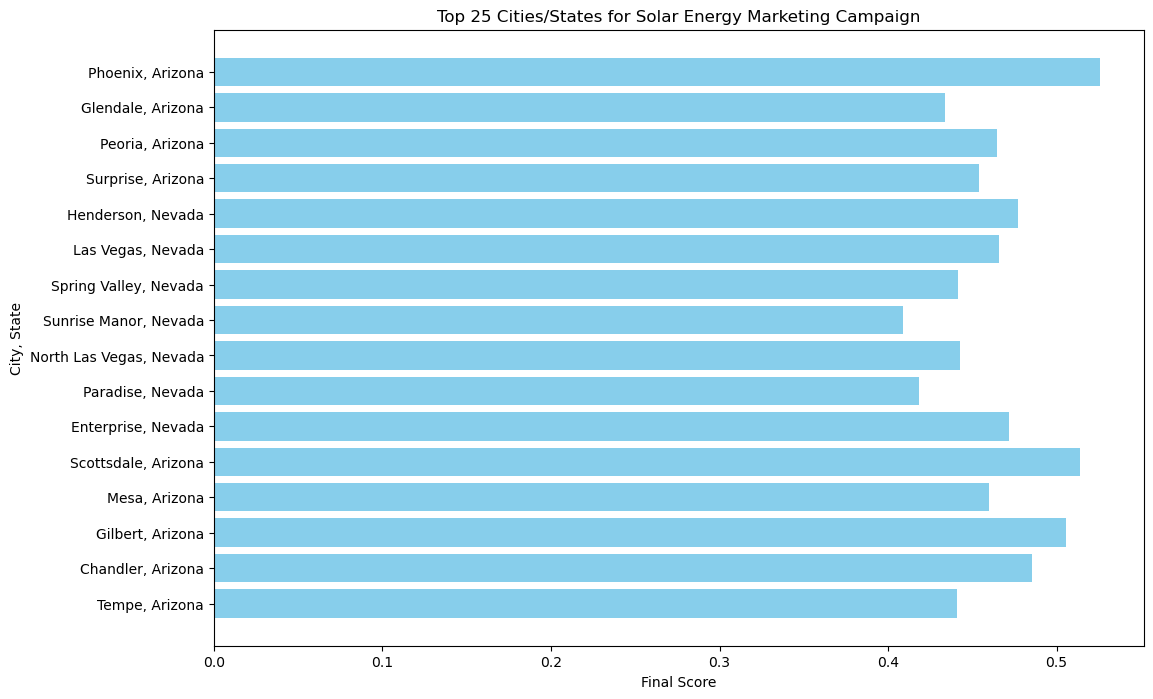

In [74]:
top_25 = df.head(25)


plt.figure(figsize=(12, 8))
plt.barh(top_25['City'] + ', ' + top_25['State'], top_25['Final_Weighted_Score'], color='skyblue')
plt.xlabel('Final Score')
plt.ylabel('City, State')
plt.title('Top 25 Cities/States for Solar Energy Marketing Campaign')
plt.gca().invert_yaxis()  
plt.show()

In [76]:
ranked_df = df.sort_values(by='Final_Weighted_Score', ascending=False)
ranked_df[['City', 'State', 'Final_Weighted_Score', 'price', 'sales', 'Final_Solar_Score', 'Median_Household_Income', 'Median_Home_Value', 'Total_1_Unit'  ]].head(25)

City       State  Final_Weighted_Score  price     sales  \
2281      Sunnyvale  California              0.726085  25.96  10324.50   
2721      Sunnyvale  California              0.717450  29.84   9858.22   
2761      Sunnyvale  California              0.713010  29.99   7923.90   
1801      Sunnyvale  California              0.705627  23.49   9038.23   
2241      Sunnyvale  California              0.697896  26.49  10768.47   
2801      Sunnyvale  California              0.688250  26.73   6037.12   
1761      Sunnyvale  California              0.687526  23.39  10279.15   
2739    Los Angeles  California              0.679841  29.99   7923.90   
2681      Sunnyvale  California              0.679073  29.38   8308.81   
2779    Los Angeles  California              0.676422  26.73   6037.12   
2250        Fremont  California              0.676005  25.96  10324.50   
2259    Los Angeles  California              0.669173  25.96  10324.50   
2276       San Jose  California              0.668736  25.96  10324.50   
2699    Los Angeles  California              0.668603  29.84   9858.22   
2690        Fremont  California              0.667370  29.84   9858.22   
2299    Los Angeles  California              0.664876  25.76   6840.73   
1721      Sunnyvale  California              0.664019  22.49  10773.12   
2730        Fremont  California              0.662929  29.99   7923.90   
1779    Los Angeles  California              0.661098  23.49   9038.23   
2275  San Francisco  California              0.661087  25.96  10324.50   
2201      Sunnyvale  California              0.659387  26.18   8972.99   
2321      Sunnyvale  California              0.658751  25.76   6840.73   
2041      Sunnyvale  California              0.658540  26.37   6264.94   
3001      Sunnyvale  California              0.658193  32.47   5918.23   
2755  San Francisco  California              0.655931  29.99   7923.90   

      Final_Solar_Score  Median_Household_Income  Median_Home_Value  \
2281          91.023733                   161670            1528500   
2721          89.644161                   161670            1528500   
2761          89.961482                   161670            1528500   
1801          90.385167                   161670            1528500   
2241          88.466903                   161670            1528500   
2801          89.369161                   161670            1528500   
1761          88.489782                   161670            1528500   
2739          90.996667                    69778             705900   
2681          87.212499                   161670            1528500   
2779          92.128548                    69778             705900   
2250          91.023733                   153475            1069700   
2259          90.140567                    69778             705900   
2276          90.771233                   125075             986700   
2699          89.412568                    69778             705900   
2690          89.644161                   153475            1069700   
2299          91.114355                    69778             705900   
1721          86.607257                   161670            1528500   
2730          89.961482                   153475            1069700   
1779          90.502492                    69778             705900   
2275          90.059600                   126187            1194500   
2201          86.081806                   161670            1528500   
2321          86.904355                   161670            1528500   
2041          86.964290                   161670            1528500   
3001          85.722516                   161670            1528500   
2755          89.637154                   126187            1194500   

      Total_1_Unit  
2281         29304  
2721         29304  
2761         29304  
1801         29304  
2241         29304  
2801         29304  
1761         29304  
2739        646358  
2681         29304  
2779        646358  
2250        

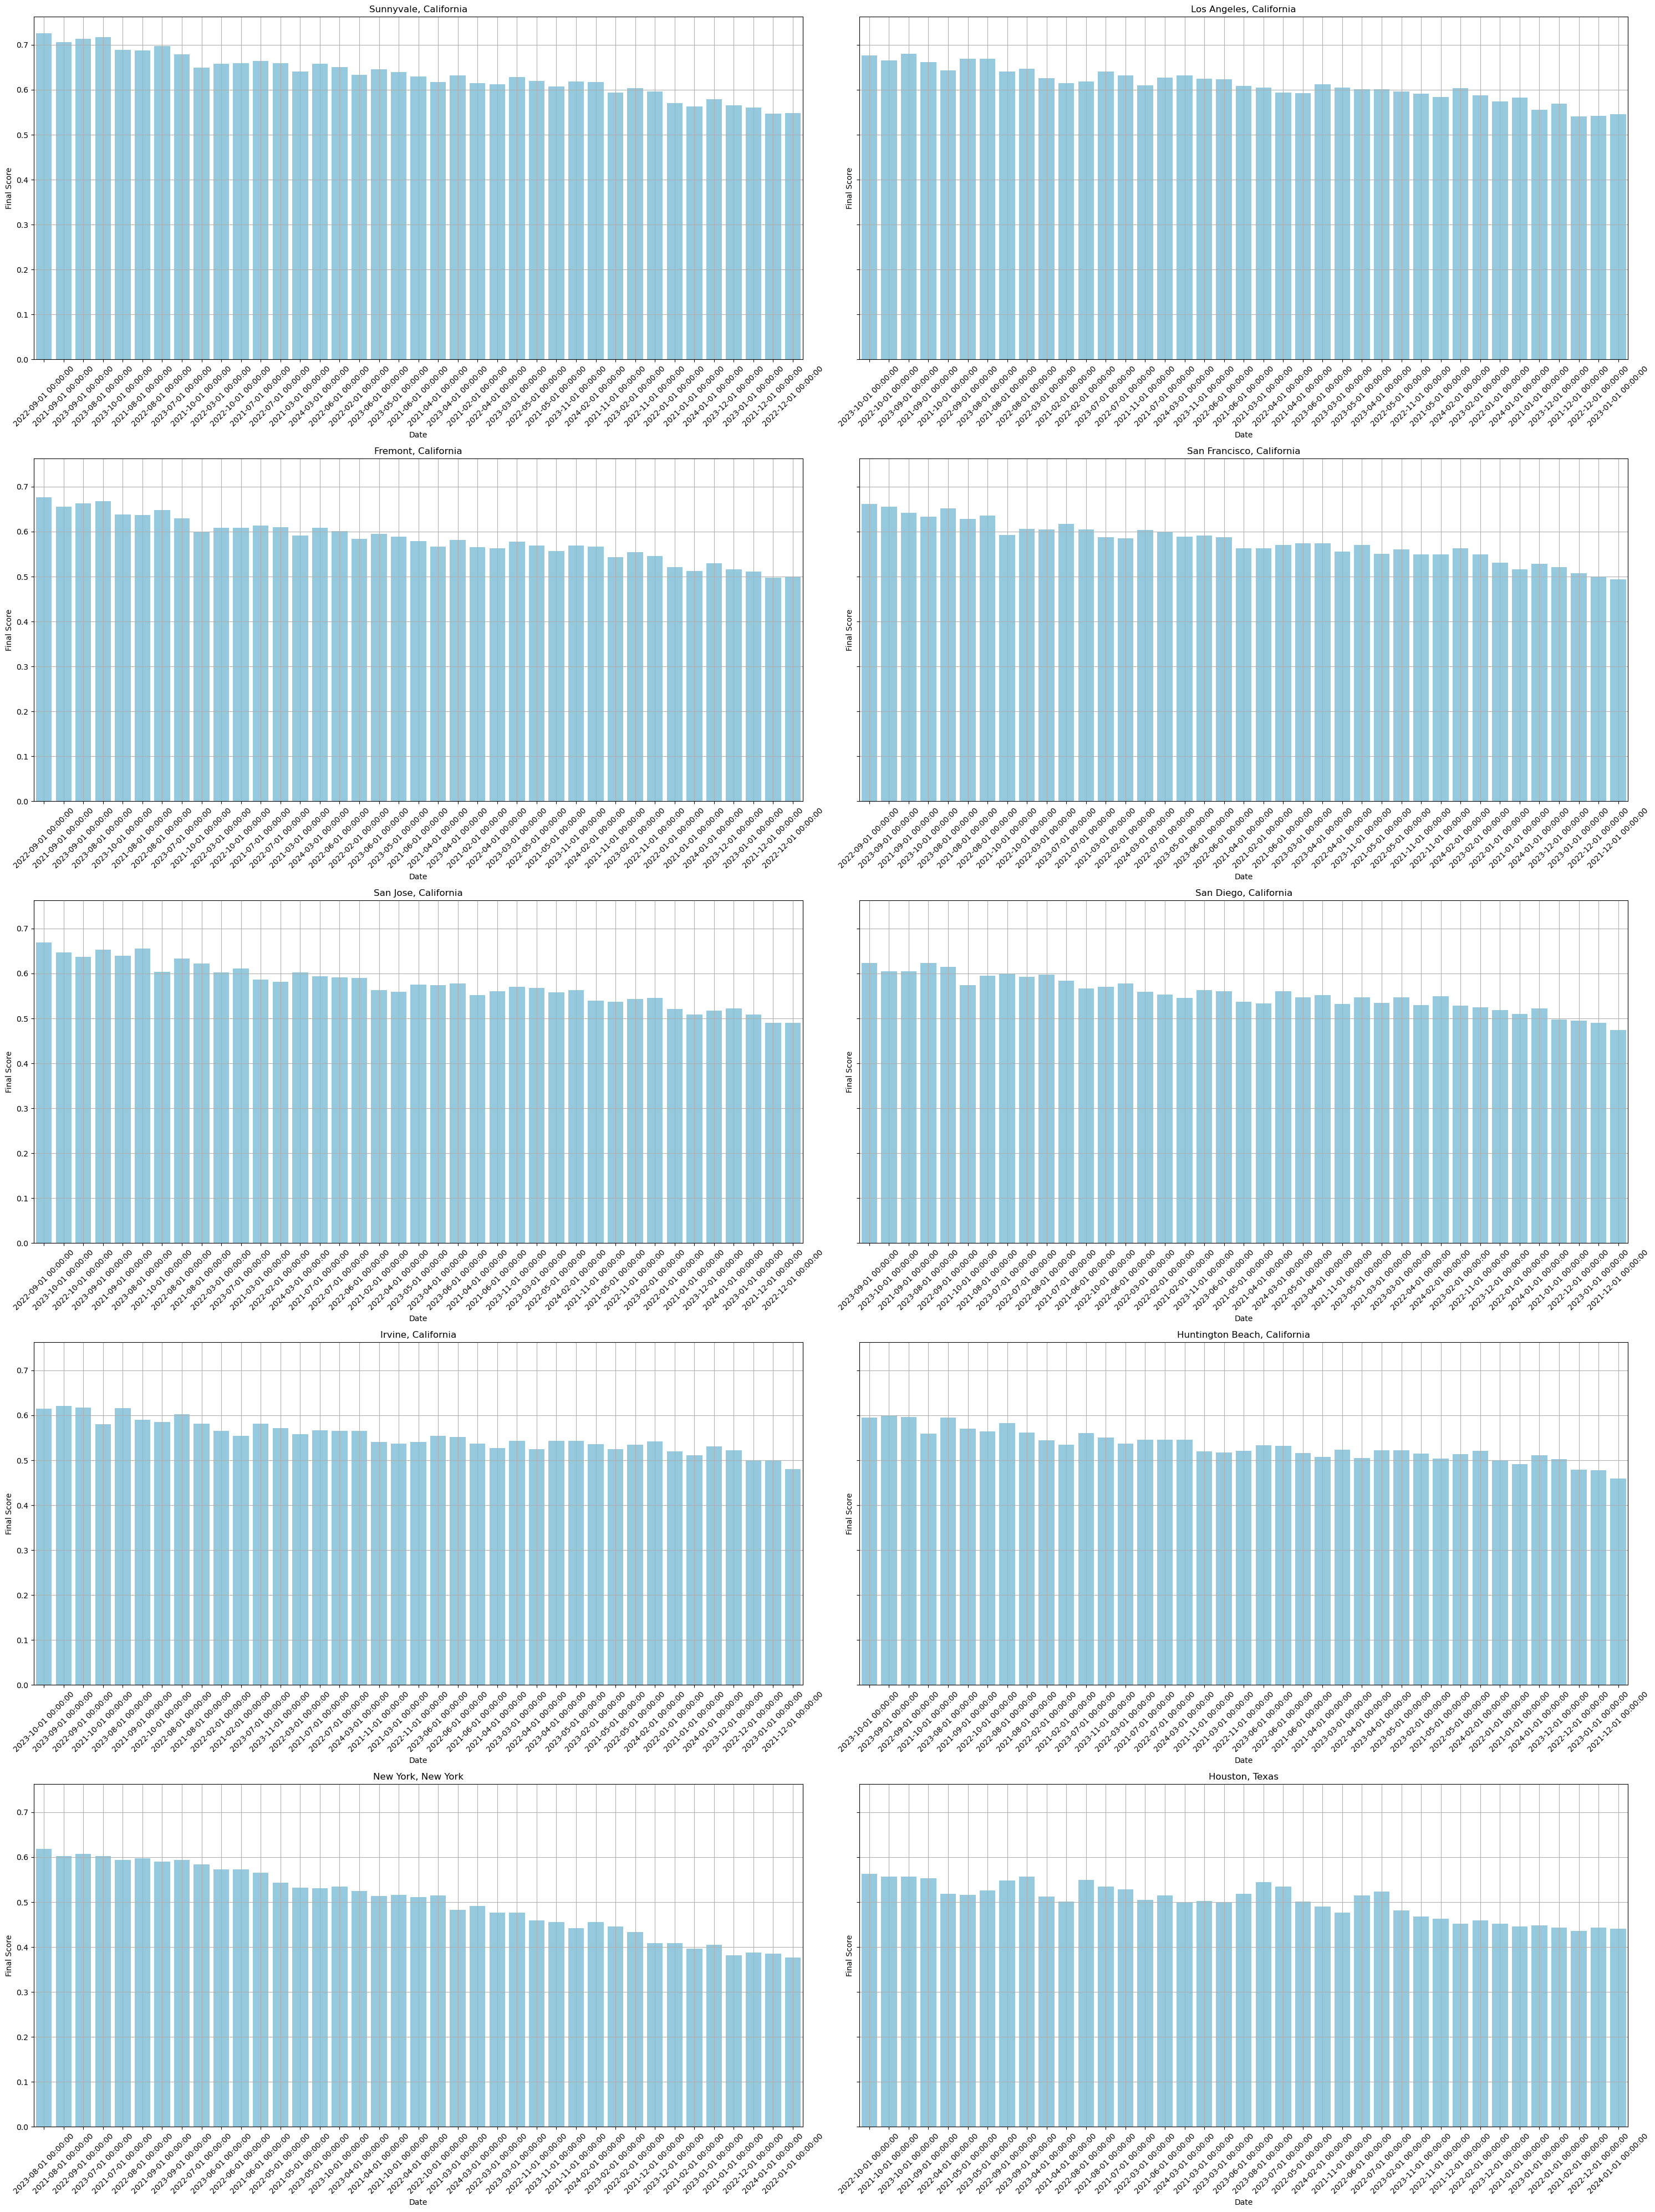

In [90]:
fig, axes = plt.subplots(5, 2, figsize=(30, 40), sharey=True)
axes = axes.flatten()


for i, city in enumerate(top_10_cities):
    city_data = top_10_df[top_10_df['City'] == city]
    sns.barplot(x=city_data['Date'], y=city_data['Final_Weighted_Score'], ax=axes[i], color='skyblue')
    axes[i].set_title(f"{city}, {city_data['State'].iloc[0]}")
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Final Score')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

C:\Users\darde\AppData\Local\Temp\ipykernel_21132\2894970440.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data['Date'] = city_data['Date'].dt.strftime('%b %Y')
C:\Users\darde\AppData\Local\Temp\ipykernel_21132\2894970440.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data['Date'] = city_data['Date'].dt.strftime('%b %Y')
C:\Users\darde\AppData\Local\Temp\ipykernel_21132\2894970440.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

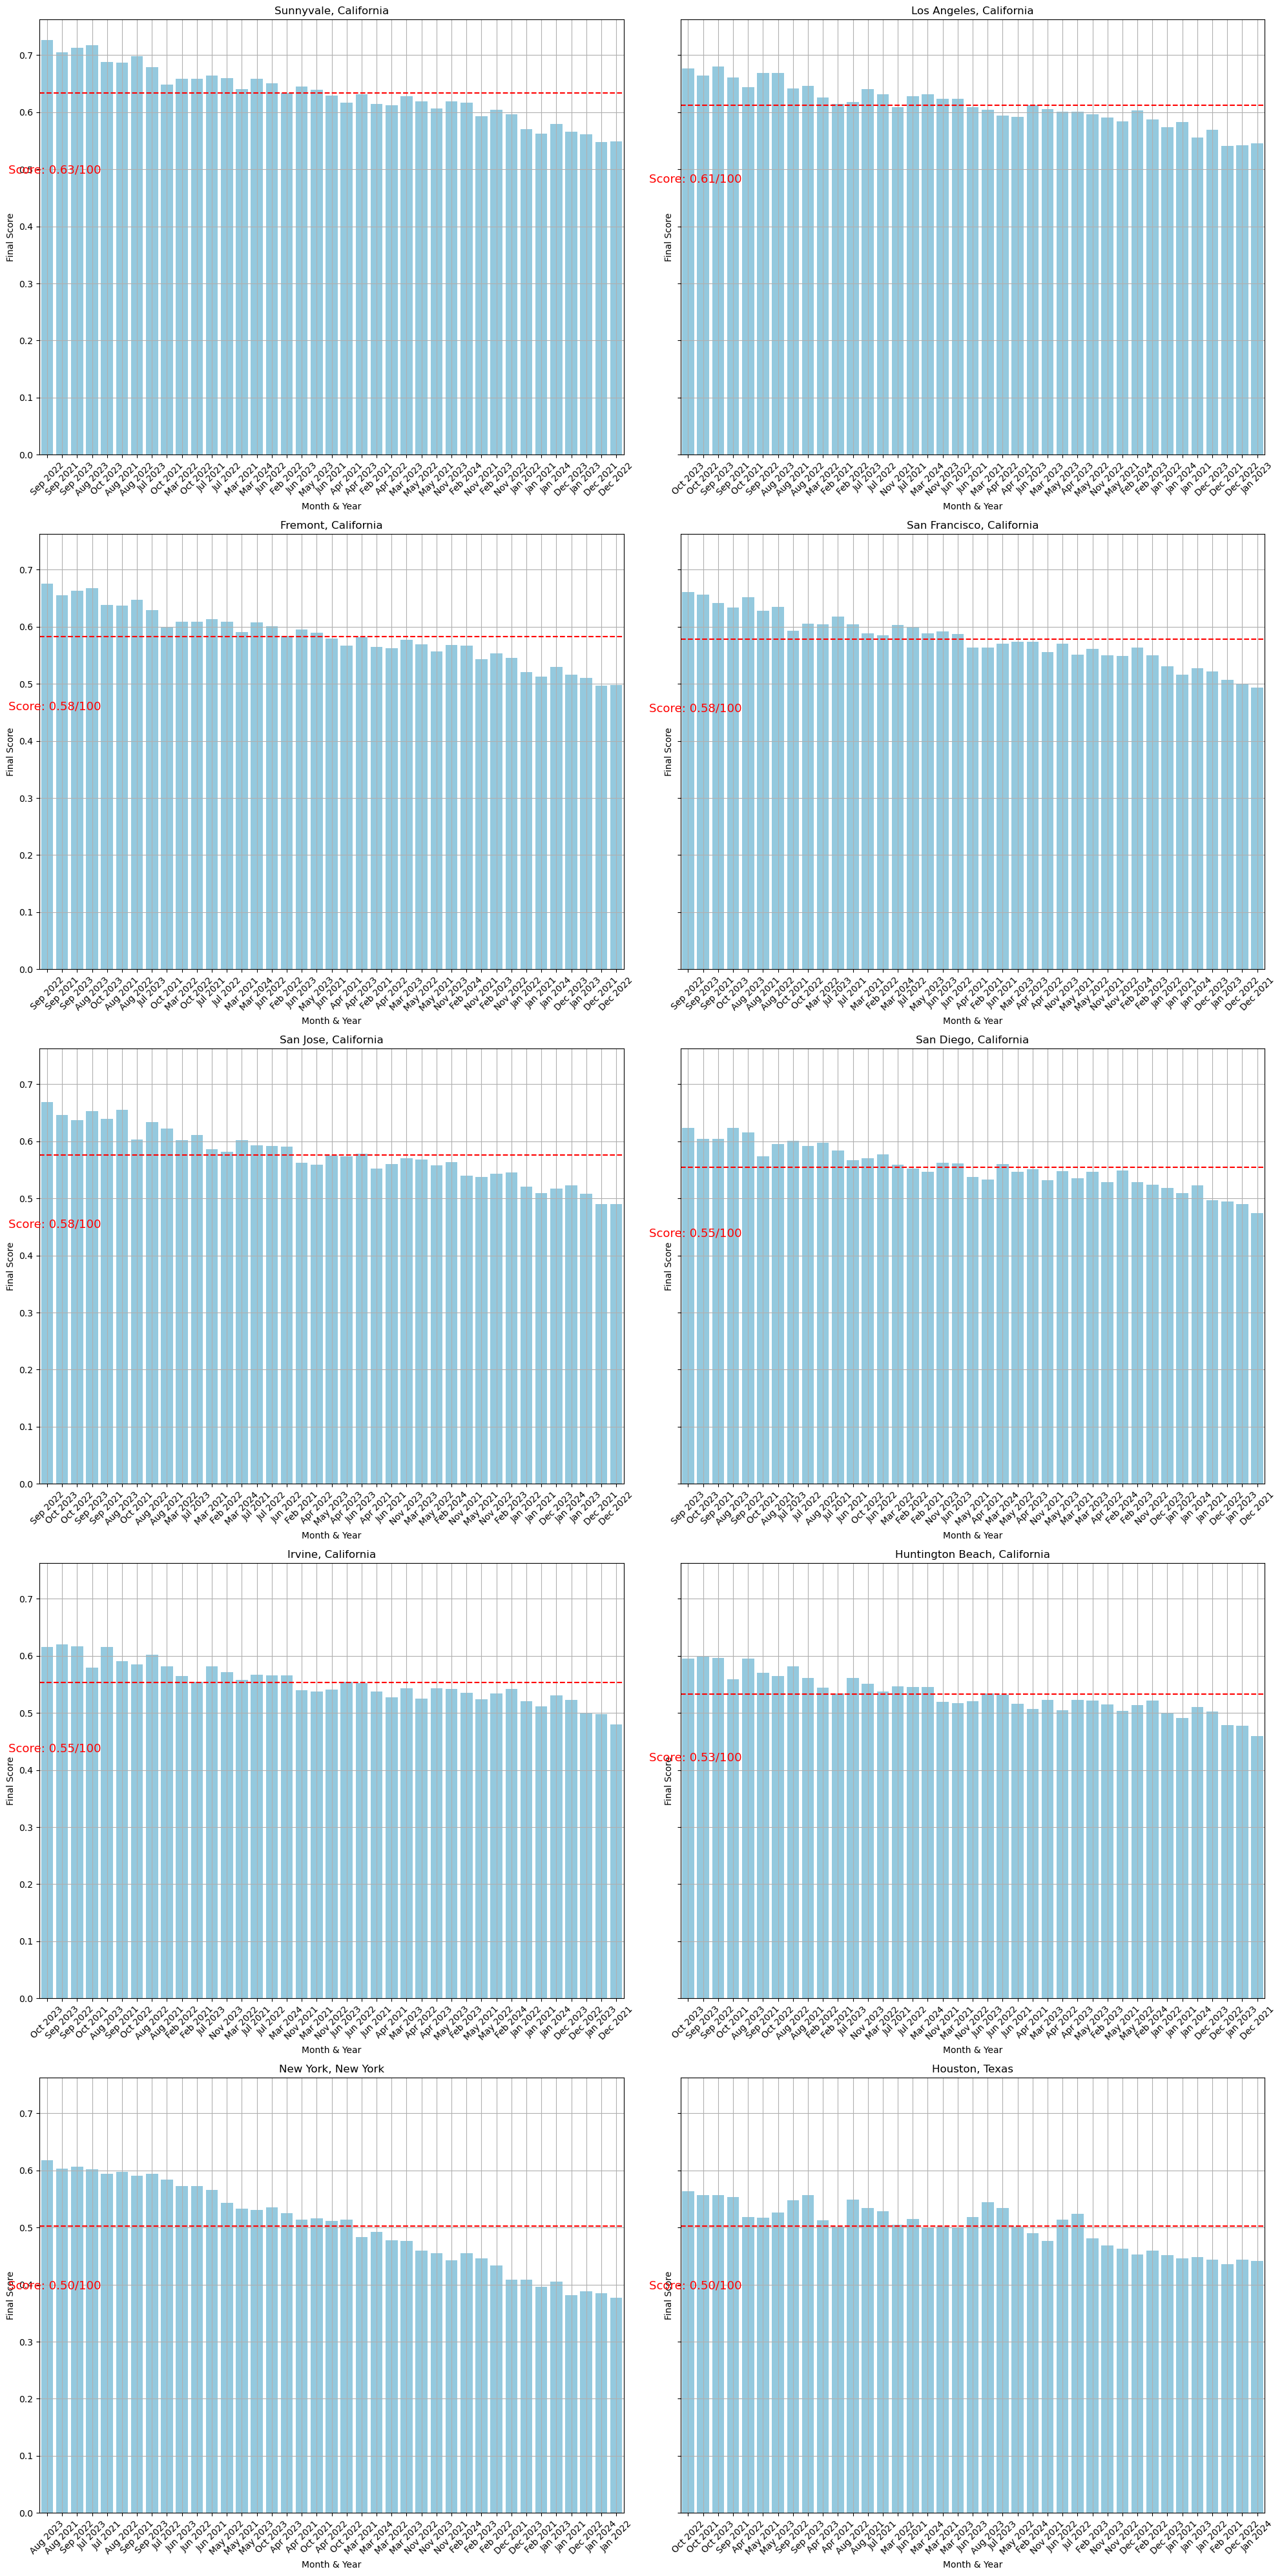

In [99]:
fig, axes = plt.subplots(5, 2, figsize=(20, 40), sharey=True)
axes = axes.flatten()


for i, city in enumerate(top_10_cities):
    city_data = top_10_df[top_10_df['City'] == city]
    city_data['Date'] = city_data['Date'].dt.strftime('%b %Y')
    sns.barplot(x=city_data['Date'], y=city_data['Final_Weighted_Score'], ax=axes[i], color='skyblue')
    

    mean_score = city_data['Final_Weighted_Score'].mean()

    axes[i].axhline(mean_score, color='red', linestyle='--')
    

    axes[i].text(x=0.5, y=mean_score + 0.02, 
                 s=f'Score: {mean_score:.2f}/100', 
                 ha='center', va='center', 
                 transform=axes[i].get_xaxis_transform(), 
                 color='red', fontsize=13)
    

    axes[i].set_title(f"{city}, {city_data['State'].iloc[0]}")
    axes[i].set_xlabel('Month & Year')
    axes[i].set_ylabel('Final Score')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True)

plt.tight_layout()
plt.show()